In [111]:
from typing import List, Dict, Tuple, Optional
import re
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import matplotlib.font_manager as fm

font_path = "./Outfit/static/Outfit-Regular.ttf"
fm.fontManager.addfont(font_path)
outfit_font = fm.FontProperties(fname=font_path)


def latex_to_svg(latex_expression: str, fontsize: int, scale: int) -> str:
    fig, ax = plt.subplots(
        figsize=(4 * scale, 2 * scale)
    )  # Adjust figure size based on font
    font_name = {"fontname": "Outfit"}
    ax.text(
        0,
        0,
        latex_expression,
        fontsize=fontsize * scale,
        ha="left",
        va="center",
        **font_name,
        color="#2C3E50",
    )
    ax.axis("off")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Save to SVG buffer
    buffer = BytesIO()
    fig.savefig(buffer, format="svg", bbox_inches="tight", transparent=True)
    plt.close(fig)
    buffer.seek(0)

    # Extract the actual SVG content (skip the XML declaration and DOCTYPE)
    svg_content = buffer.getvalue().decode("utf-8")
    svg_content = re.search(r"<svg.*?</svg>", svg_content, re.DOTALL).group(0)

    return svg_content


def create_dp_visualization(
    problem: Dict[str, str],
    width: int = 650,
    height: int = 650,
    scale: int = 4,
) -> str:
    """
    Creates an SVG visualization of a dynamic programming problem with LaTeX support.
    """
    # task_color = "#2C3E50"  # black
    # base_color = "#3498DB"  # dark yellow
    # dependency_color = "#27AE60"  # blue
    # computed_color = "#9B59B6"  # green

    task_color = "#2C3E50"  # black
    base_color = "#3498DB"  # dark yellow
    dependency_color = "#27AE60"  # blue
    computed_color = "#9B59B6"  # green

    def create_grid(
        start_x: int,
        start_y: int,
        rows: int,
        cols: int,
        scale: int,
    ) -> str:
        svg = []
        cell_size = 32 * scale  # 0.8 * width / cols
        stroke_width = 1.5 * scale
        for i in range(rows + 1):
            svg.append(
                f'<line x1="{start_x - 0.5*stroke_width}" y1="{start_y + i * cell_size}" '
                f'x2="{start_x + cols * cell_size + 0.5*stroke_width}" y2="{start_y + i * cell_size}" '
                f'stroke="black" stroke-width="{stroke_width}"/>'
            )

        if rows > 1:
            for i in range(rows):
                svg.append(
                    f'<text x="{start_x - 12*scale}" y="{start_y + (i+0.5) * cell_size}" '
                    f'font-size="{12*scale}" fill="#2C3E50" text-anchor="center" '
                    f'dominant-baseline="middle">{i}</text>'
                )

        svg.append(
            f'<text x="{start_x - 20*scale}" y="{start_y + rows * cell_size * .5}" '
            f'font-size="{12*scale}" fill="#2C3E50" text-anchor="middle" '
            f'transform="rotate(-90, {start_x - 20*scale}, {start_y + rows * cell_size * .5})">'
            f'{problem["each_row"]}</text>'
        )

        for j in range(cols + 1):
            svg.append(
                f'<line x1="{start_x + j * cell_size}" y1="{start_y - 0.5*stroke_width}" '
                f'x2="{start_x + j * cell_size}" y2="{start_y + rows * cell_size + 0.5*stroke_width}" '
                f'stroke="black" stroke-width="{stroke_width}"/>'
            )

        for j in range(cols):
            svg.append(
                f'<text x="{start_x + (j+0.5) * cell_size}" y="{start_y - 5*scale}" '
                f'font-size="{12*scale}" fill="#2C3E50" text-anchor="middle">{j}</text>'
            )

        svg.append(
            f'<text x="{start_x + cols * cell_size * .5}" y="{start_y - 20*scale}" '
            f'font-size="{12*scale}" fill="#2C3E50" text-anchor="middle">'
            f'{problem["each_col"]}</text>'
        )

        # Color cells
        for row, col in problem.get("base_cases", []):
            svg.append(
                f'<rect x="{start_x + col * cell_size + 0.5*stroke_width}" '
                f'y="{start_y + row * cell_size + 0.5*stroke_width}" '
                f'width="{cell_size - stroke_width}" height="{cell_size - stroke_width}" '
                f'fill="{base_color}" opacity="0.6"/>'
            )

        # If computed cell is not a list, make it a list
        if not isinstance(problem["computed_cell"], list):
            problem["computed_cell"] = [problem["computed_cell"]]

        for row, col in problem["computed_cell"]:
            svg.append(
                f'<rect x="{start_x + col * cell_size + 0.5*stroke_width}" '
                f'y="{start_y + row * cell_size + 0.5*stroke_width}" '
                f'width="{cell_size - stroke_width}" height="{cell_size - stroke_width}" '
                f'fill="{computed_color}" opacity="0.6"/>'
            )

        for row, col in problem.get("dependencies", []):
            svg.append(
                f'<rect x="{start_x + col * cell_size + 0.5*stroke_width}" '
                f'y="{start_y + row * cell_size + 0.5*stroke_width}" '
                f'width="{cell_size - stroke_width}" height="{cell_size - stroke_width}" '
                f'fill="{dependency_color}" opacity="0.6"/>'
            )

        return "\n".join(svg)

    # Start building the SVG
    svg = [
        f'<svg xmlns="http://www.w3.org/2000/svg" width="{width*scale}" height="{height*scale}">',
        "<defs>",
        '  <marker id="arrowhead" markerWidth="10" markerHeight="7" ',
        '    refX="9" refY="3.5" orient="auto">',
        '    <polygon points="0 0, 10 3.5, 0 7" fill="#4A90E2"/>',
        "  </marker>",
        "  <style>",
        '    @import url("https://fonts.googleapis.com/css2?family=Outfit:wght@400;700&amp;display=swap");',
        "    text { font-family: Outfit; }",
        "  </style>",
        "</defs>",
        # Background gradient
        "<defs>",
        '  <linearGradient id="background-gradient" x1="0%" y1="0%" x2="100%" y2="100%">',
        '    <stop offset="0%" style="stop-color:#F5F5F5;stop-opacity:.5" />',
        '    <stop offset="100%" style="stop-color:#000000;stop-opacity:.5" />',
        "  </linearGradient>",
        "</defs>",
        f'<rect x="0" y="0" width="{width*scale}" height="{height*scale}" fill="white" />',
        f'<rect x="0" y="0" width="{width*scale}" height="{height*scale}" fill="url(#background-gradient)" />',
        # Title
        f'<text x="{50*scale}" y="{50*scale}" font-size="{24*scale}" font-weight="bold">',
        f'{problem.get("title", "Dynamic Programming Visualization")}',
        "</text>",
    ]

    # Add LaTeX equations with proper positioning
    y_position = 80 * scale
    y_increment = 30 * scale
    latex_fontsize = 10
    latex_offset = 154 * scale
    # Task description (no LaTeX)
    svg.append(
        f'<text x="{50*scale}" y="{y_position}" font-size="{14*scale}" fill="#2C3E50">'
        f'<tspan font-weight="bold">Task:</tspan> '
        f'<tspan fill="{task_color}">{problem["task"]}</tspan></text>'
    )
    y_position += y_increment

    # DP definition (with LaTeX)
    svg.append(
        f'<text x="{50*scale}" y="{y_position}" font-size="{14*scale}" fill="#2C3E50">'
        f'<tspan font-weight="bold">DP:</tspan></text>'
    )
    dp_svg = latex_to_svg(problem["dp"], fontsize=latex_fontsize, scale=scale)
    svg.append(
        f'<g transform="translate({75*scale}, {y_position-latex_offset})">{dp_svg}</g>'
    )
    y_position += y_increment

    # Base case (with LaTeX), color is base_color
    svg.append(
        f'<text x="{50*scale}" y="{y_position}" font-size="{14*scale}" fill="#2C3E50">'
        f'<tspan font-weight="bold">Base:</tspan></text>'
    )
    base_svg = latex_to_svg(problem["base_case"], fontsize=latex_fontsize, scale=scale)
    svg.append(
        f'<g fill="{base_color}" transform="translate({85*scale}, {y_position-latex_offset})">{base_svg}</g>'
    )
    y_position += y_increment

    # Induction step (with LaTeX)
    svg.append(
        f'<text x="{50*scale}" y="{y_position}" font-size="{14*scale}" fill="#2C3E50">'
        f'<tspan font-weight="bold">Induction:</tspan></text>'
    )
    induction_svg = latex_to_svg(
        problem["induction_step"], fontsize=latex_fontsize, scale=scale
    )
    induction_adj = 3 if problem.get("adj_induction_down", False) else 0
    svg.append(
        f'<g transform="translate({115*scale}, {y_position-latex_offset+induction_adj*scale})">{induction_svg}</g>'
    )
    y_position += y_increment

    # Intuition (with LaTeX)
    svg.append(
        f'<text x="{50*scale}" y="{y_position}" font-size="{14*scale}" fill="#2C3E50">'
        f'<tspan font-weight="bold">Intuition:</tspan></text>'
    )
    intuition_svg = latex_to_svg(
        problem["intuition"], fontsize=latex_fontsize, scale=scale
    )
    svg.append(
        f'<g transform="translate({108*scale}, {y_position-latex_offset})">{intuition_svg}</g>'
    )

    # Add grid
    svg.append(
        create_grid(
            80 * scale, y_position + 60 * scale, problem["rows"], problem["cols"], scale
        )
    )

    # Add ghost text over the whole thing with "sambhavg.github.io/blog/dp"
    svg.append(
        f'<text x="{width/2*scale}" y="{height/2*scale}" font-size="{36*scale}" fill="#2C3E50" opacity="0.10" '
        f'text-anchor="middle" dominant-baseline="middle">'
        f"sambhavg.github.io/blog/dp"
        "</text>"
    )

    # Add link
    svg.append(
        f'<text x="{(width-20)*scale}" y="{(height-20)*scale}" font-size="{14*scale}" fill="#2C3E50" '
        f'text-anchor="end" dominant-baseline="middle">'
        f'<a href="{problem["link"]}" target="_blank">{problem["link"]}</a>'
        "</text>"
    )

    svg.append("</svg>")
    return "\n".join(svg)

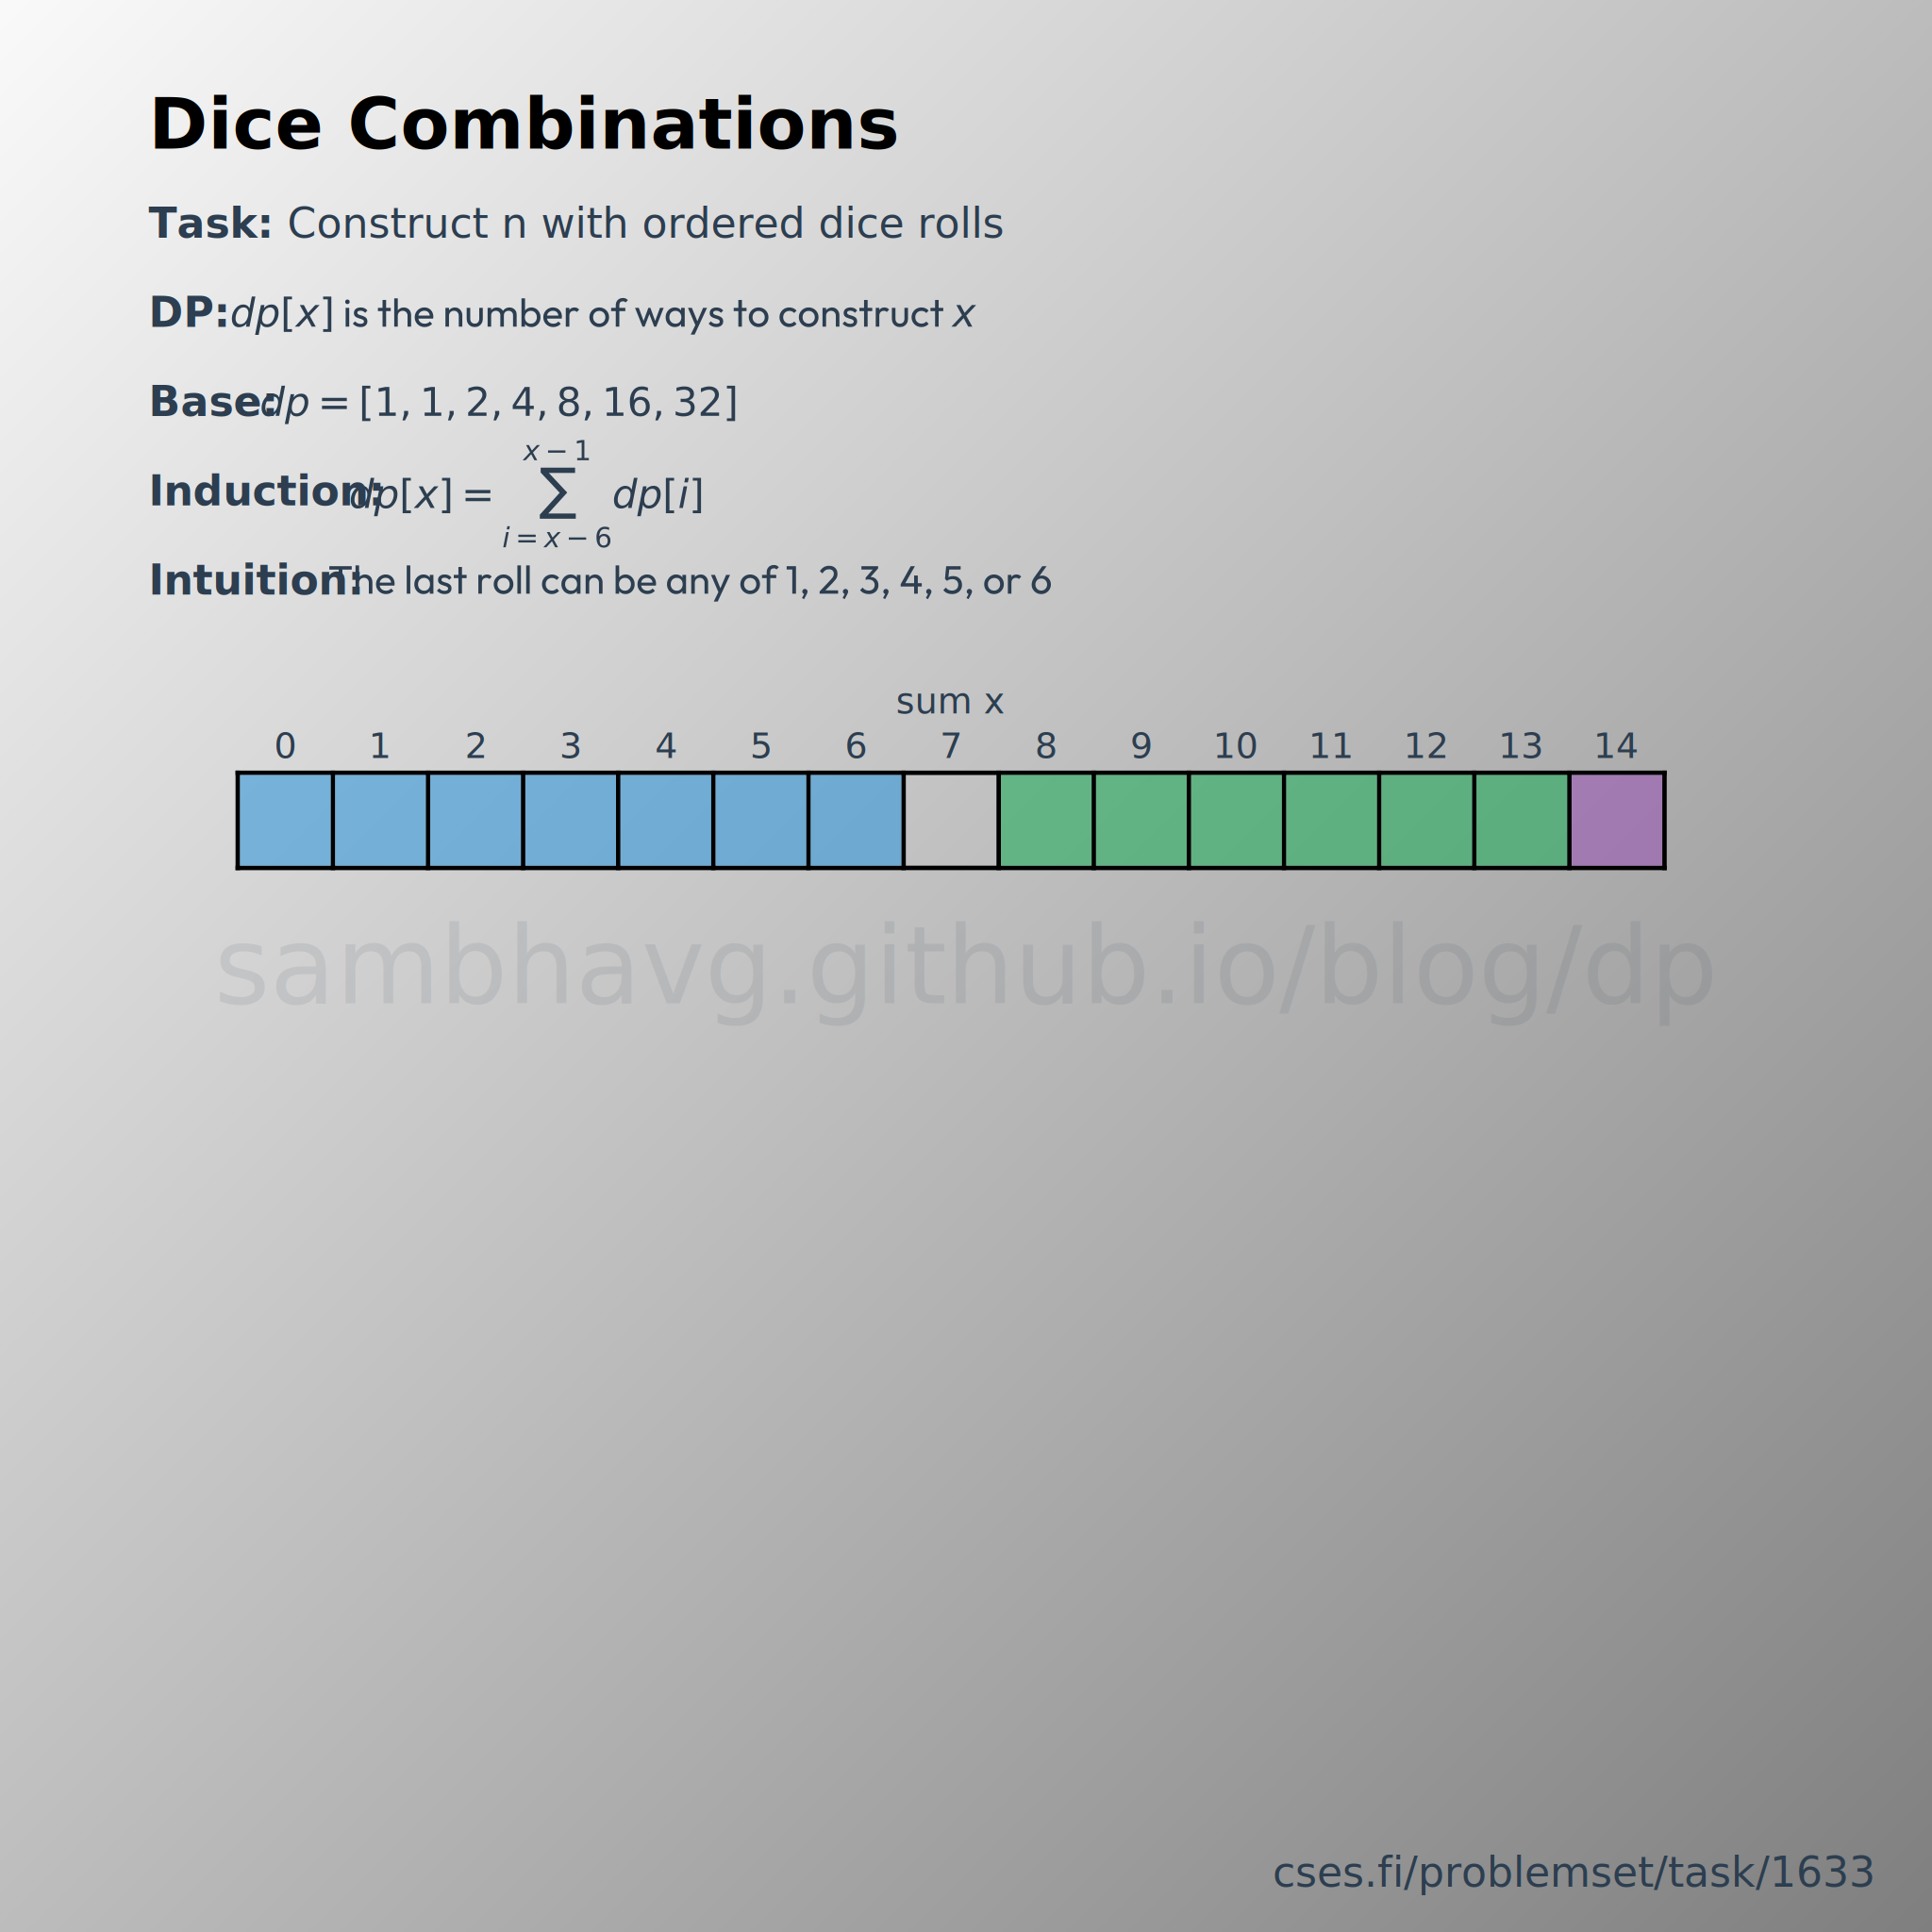

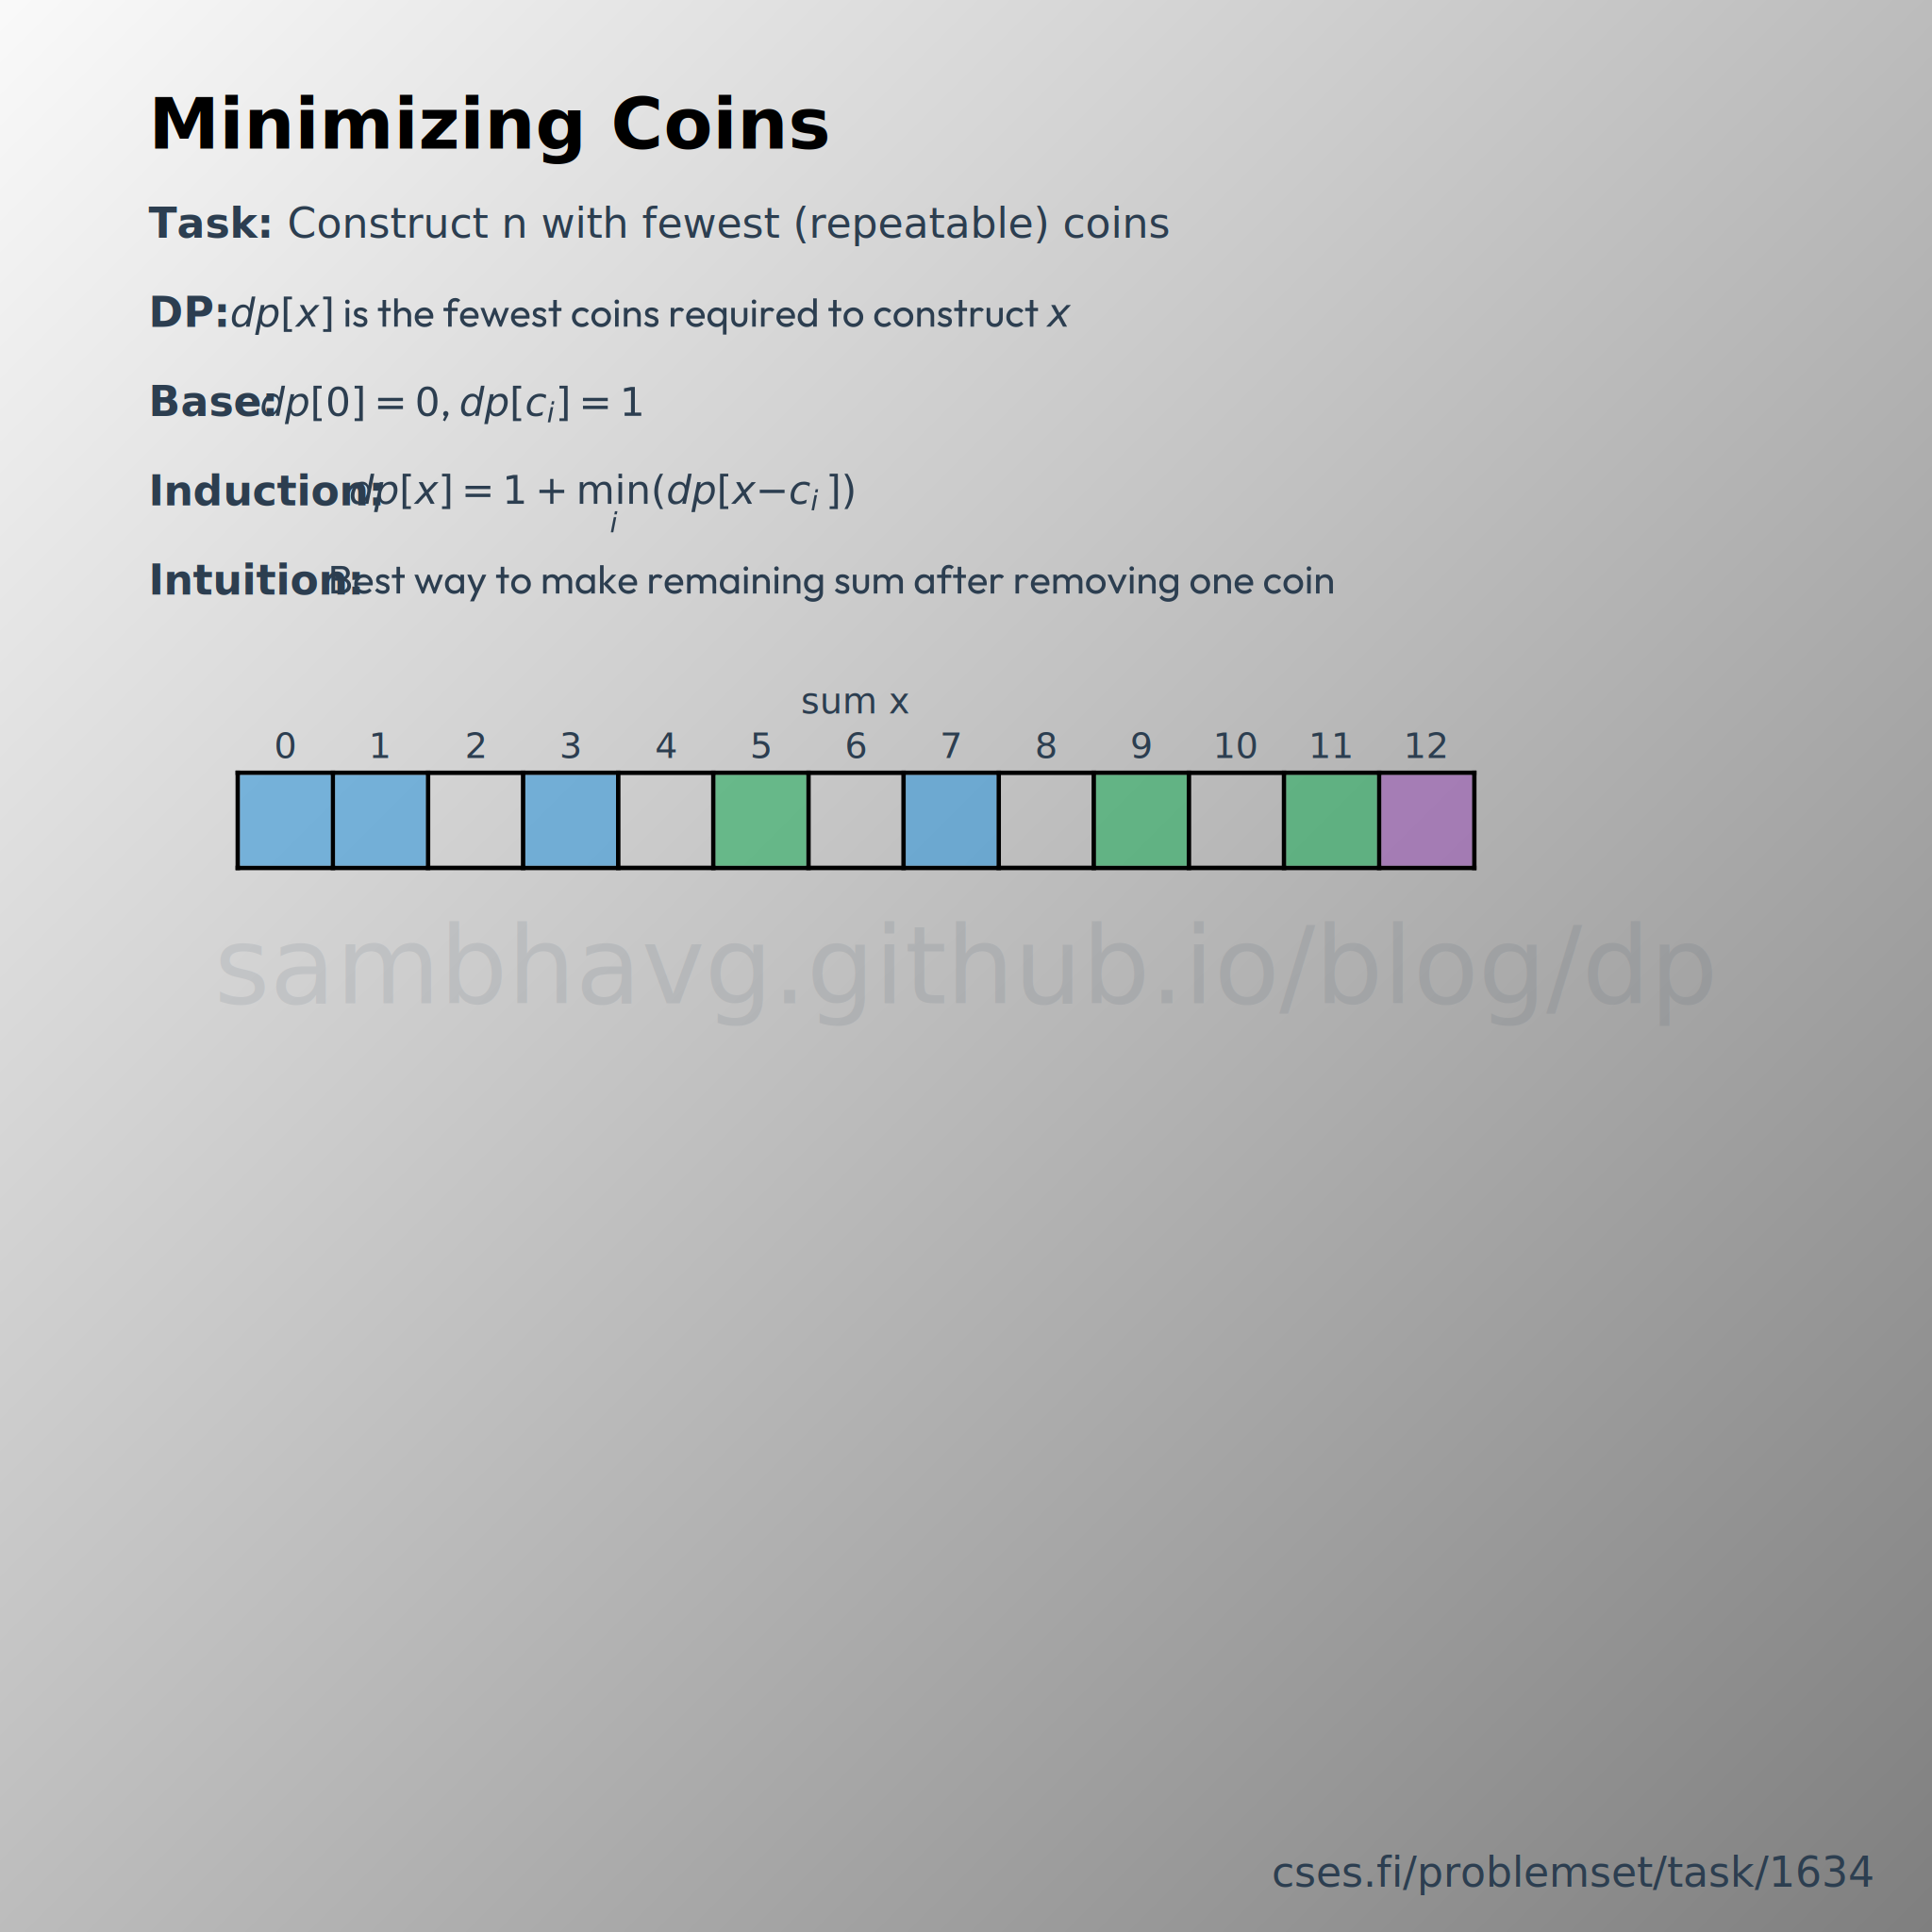

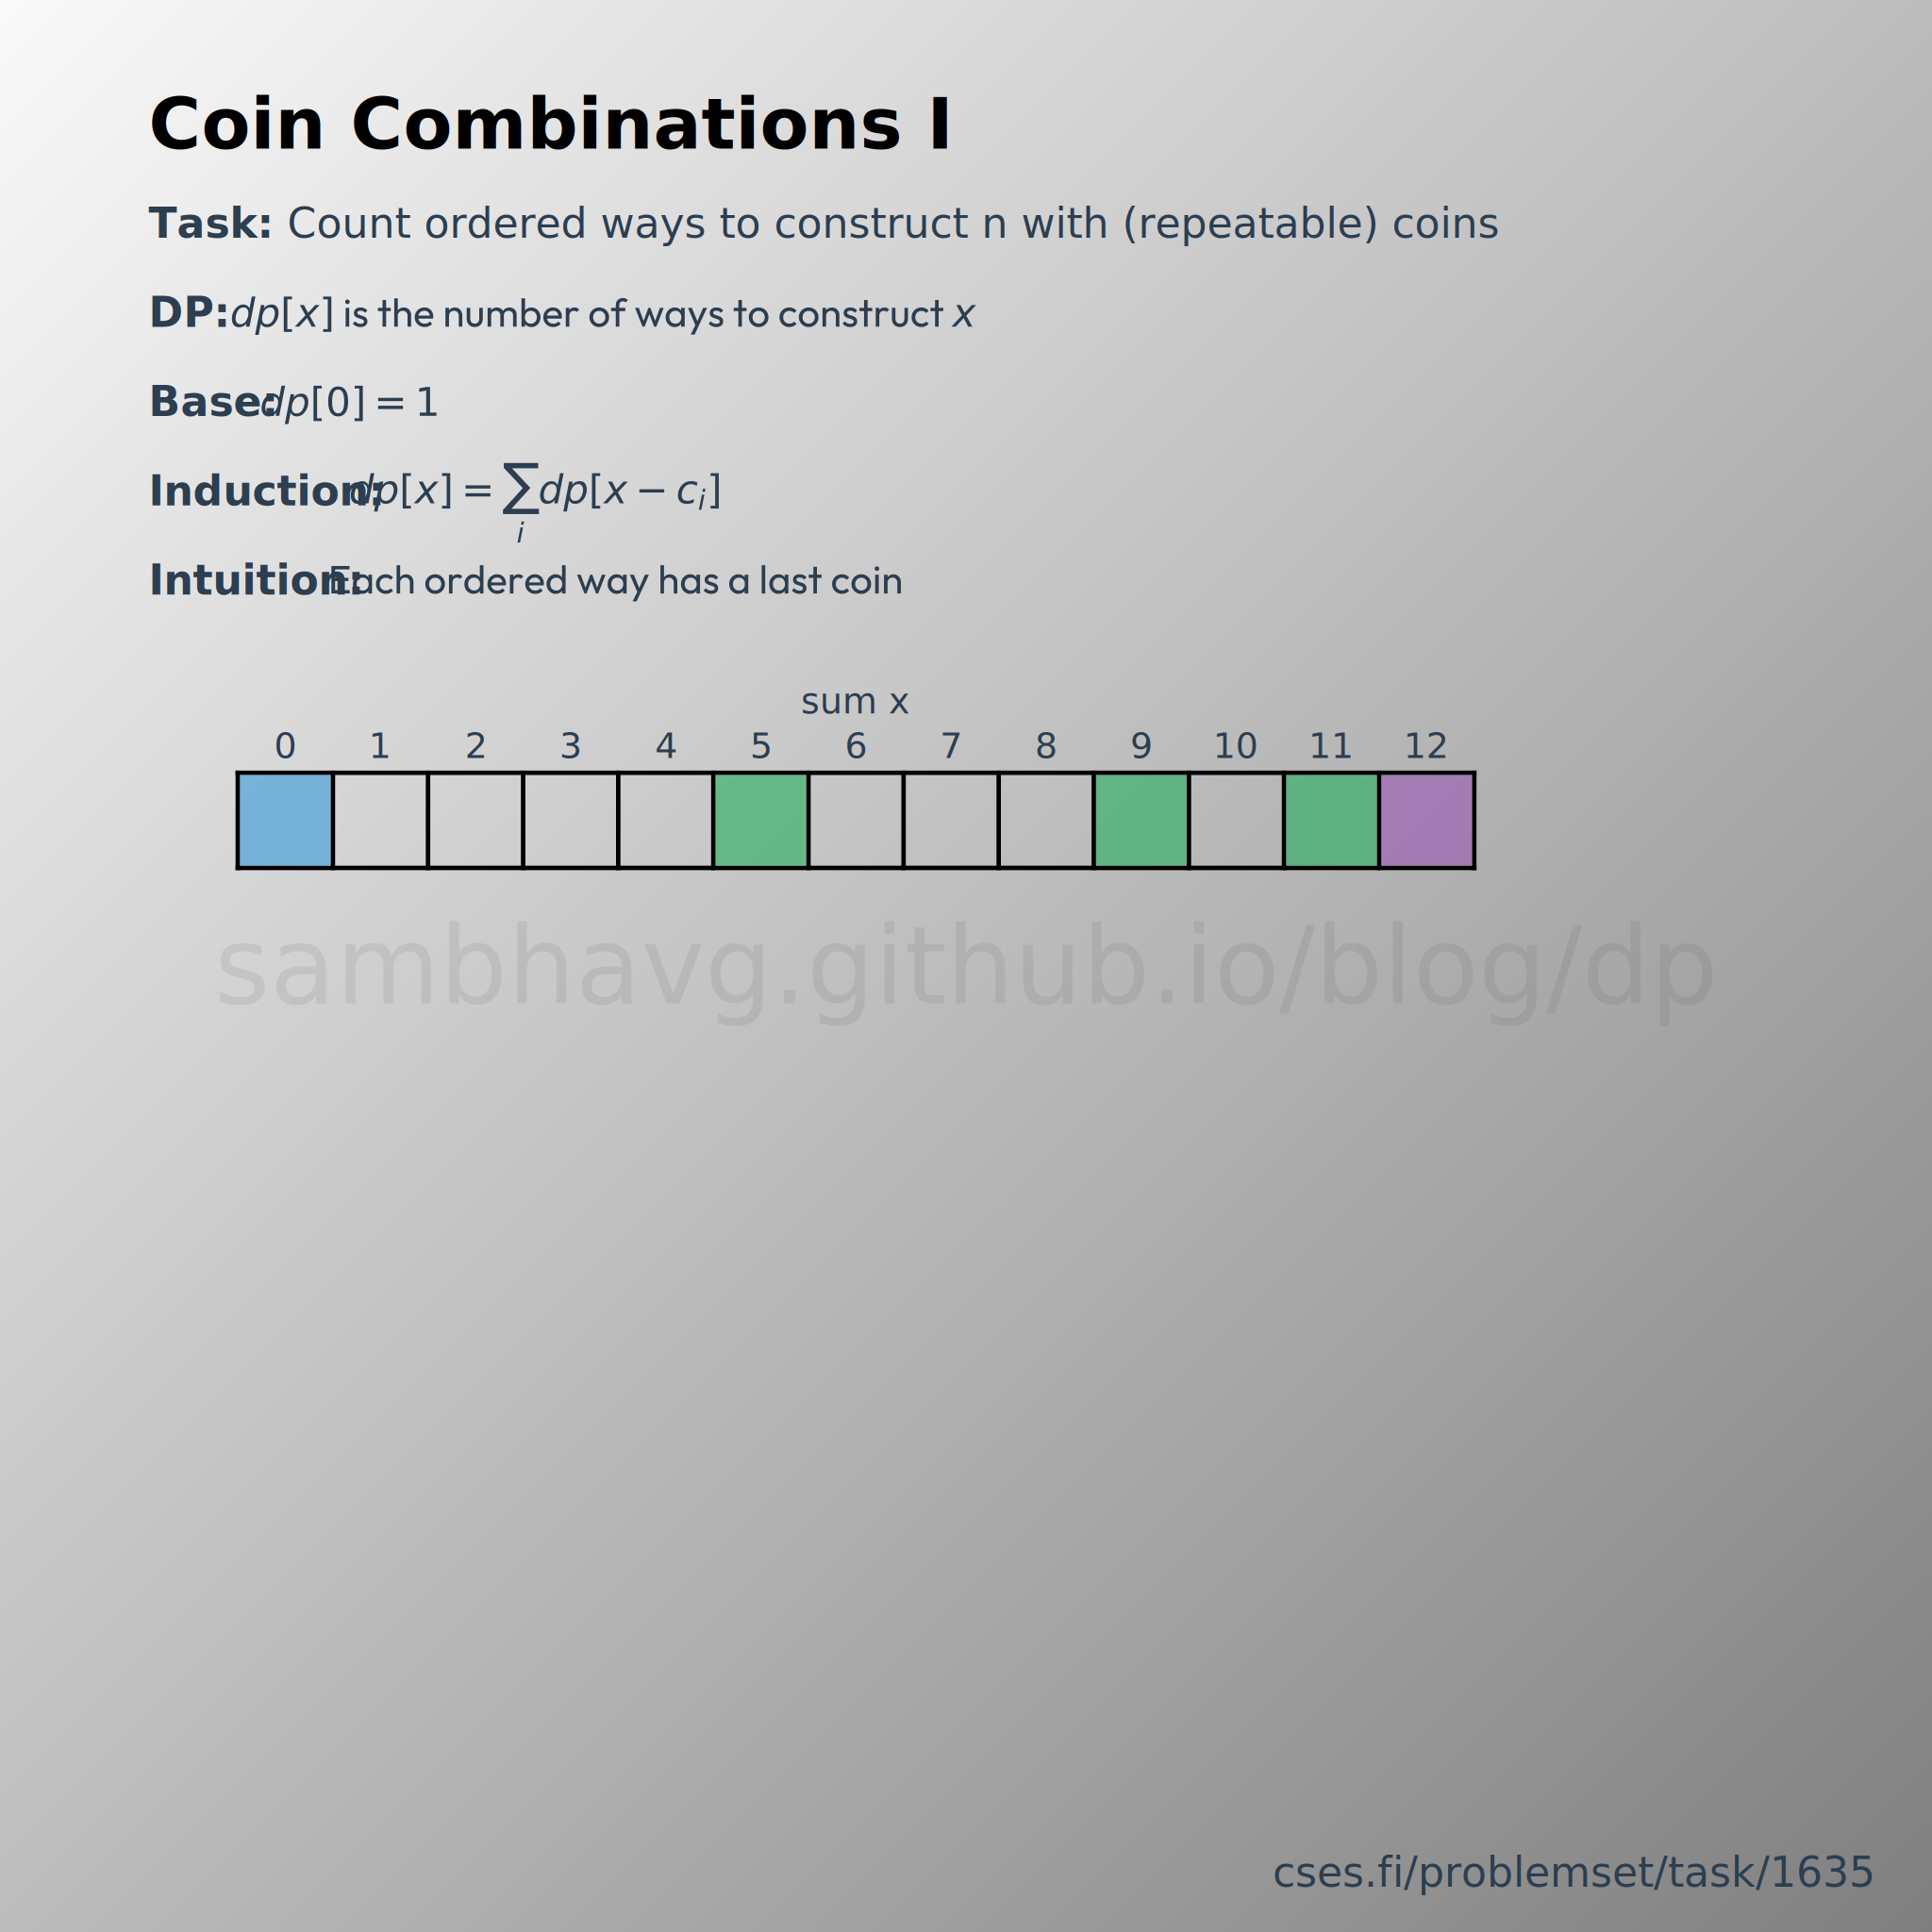

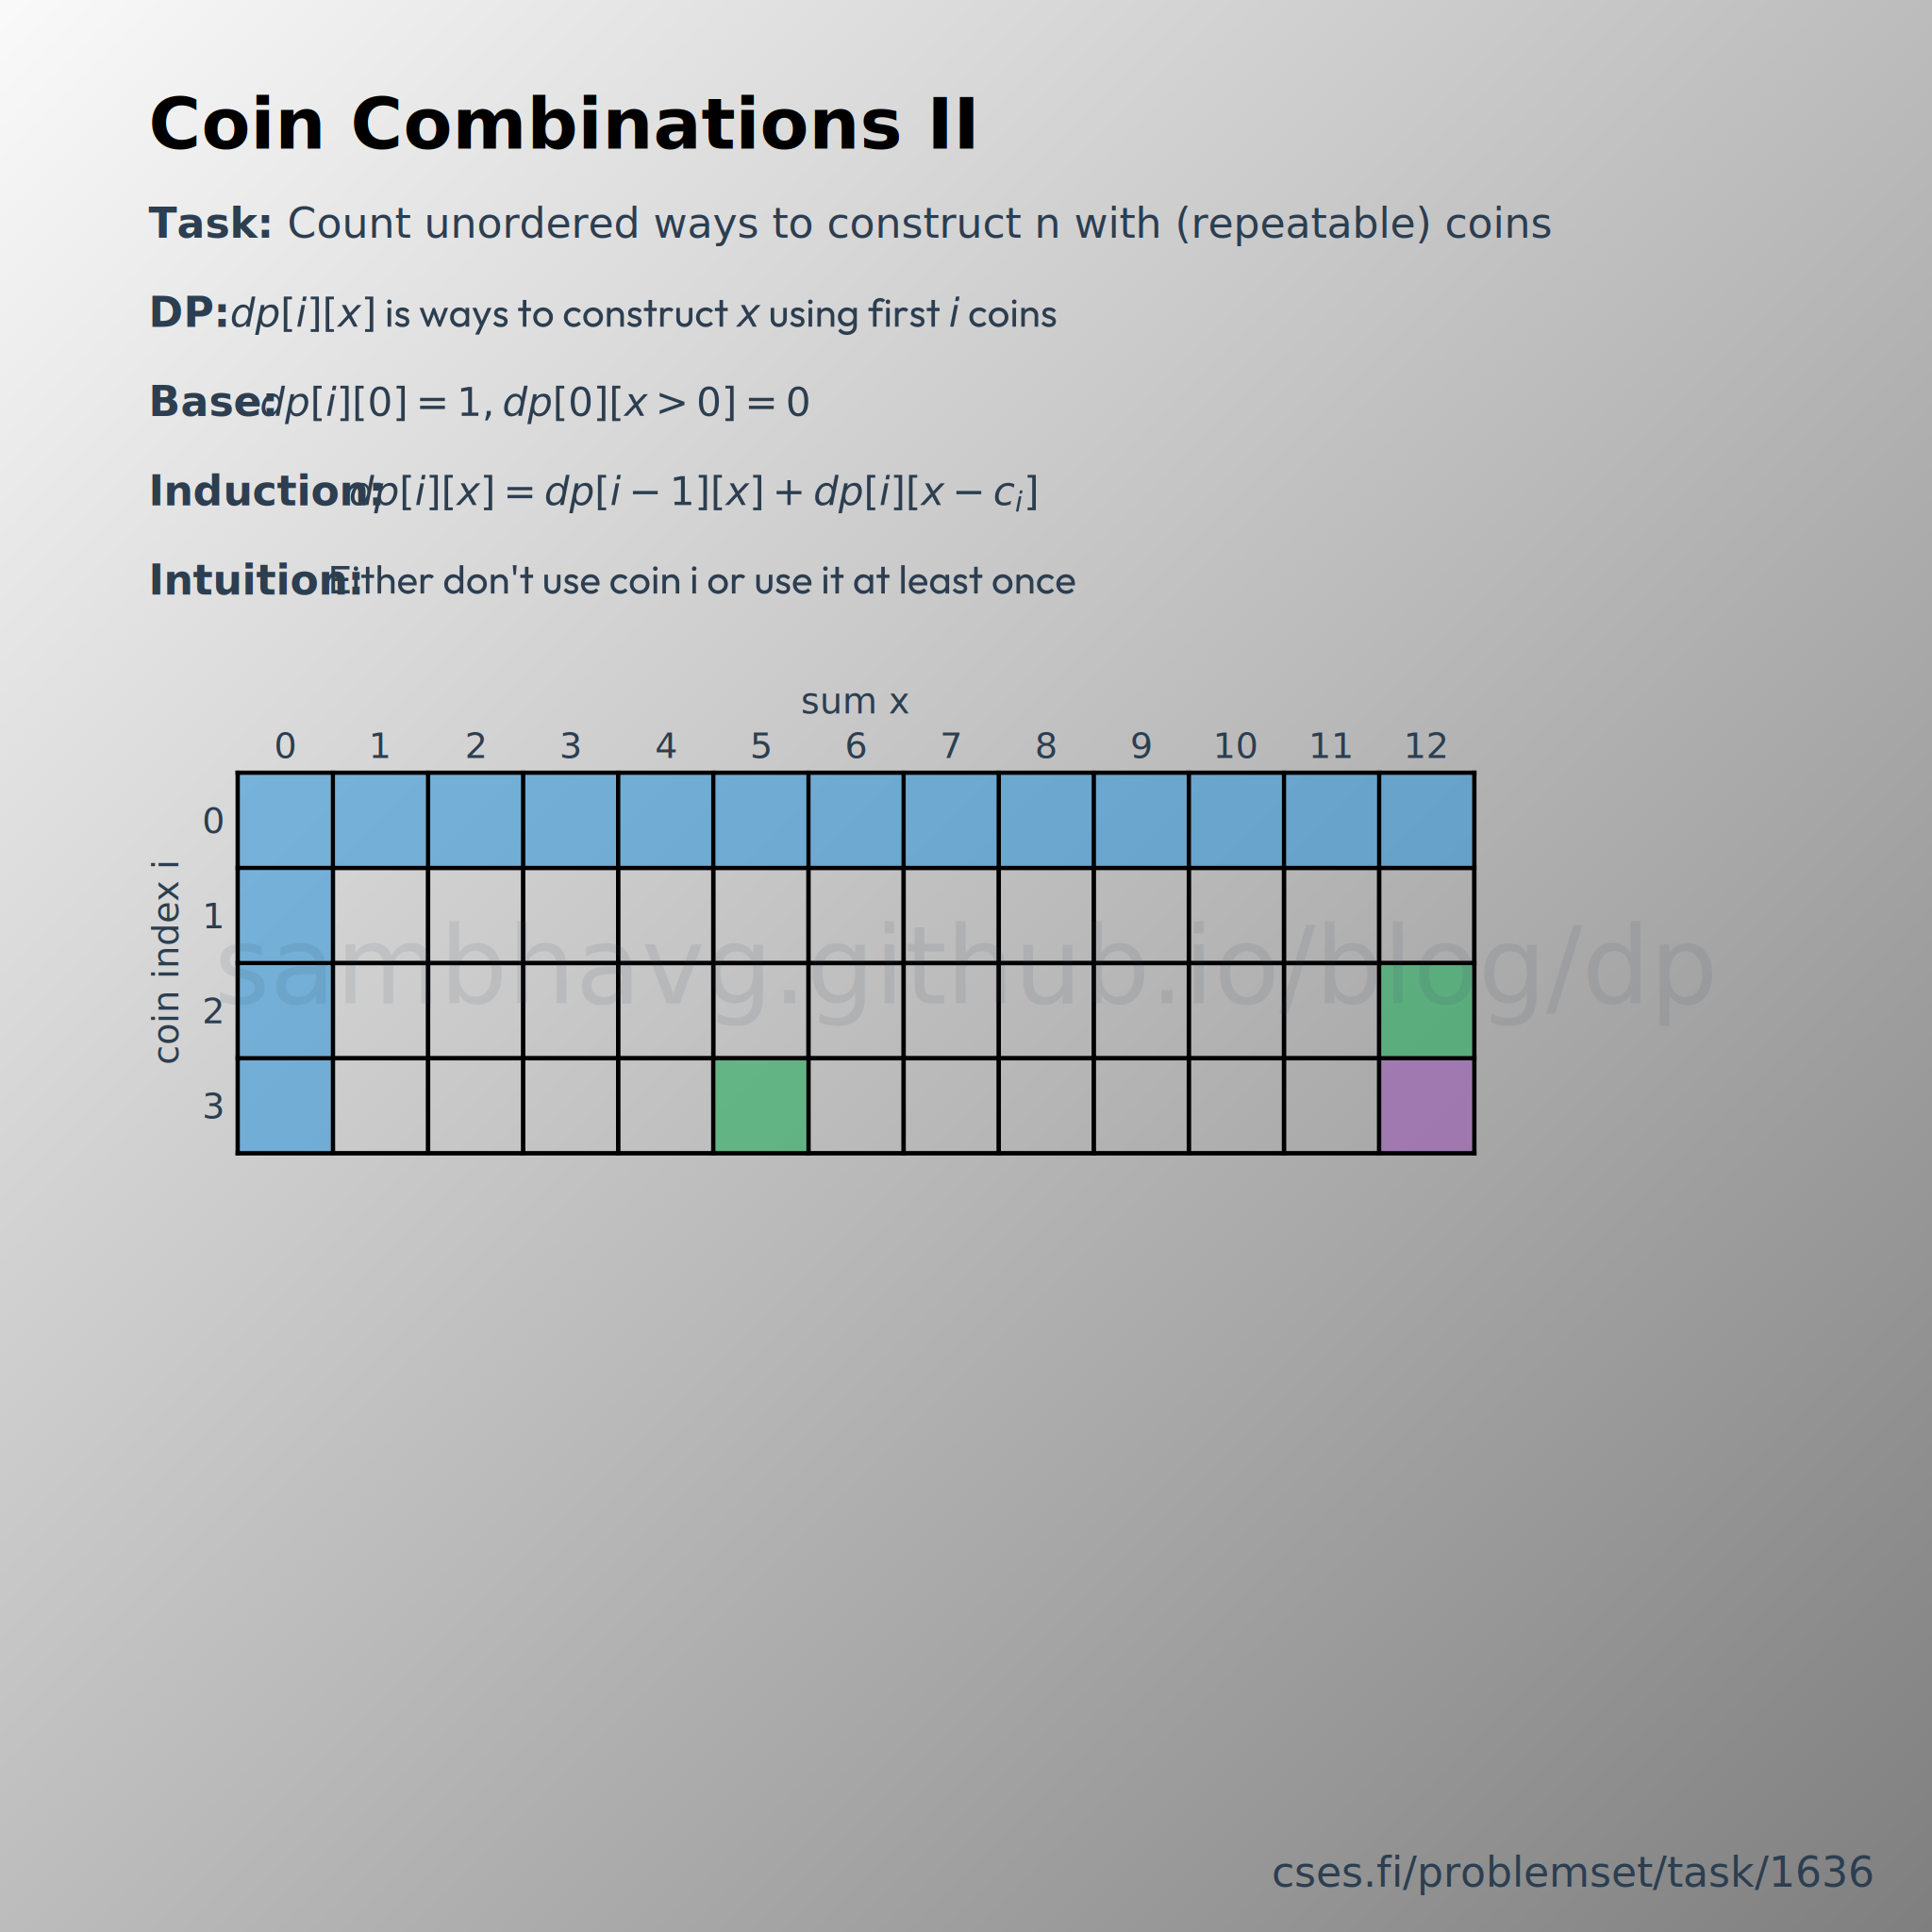

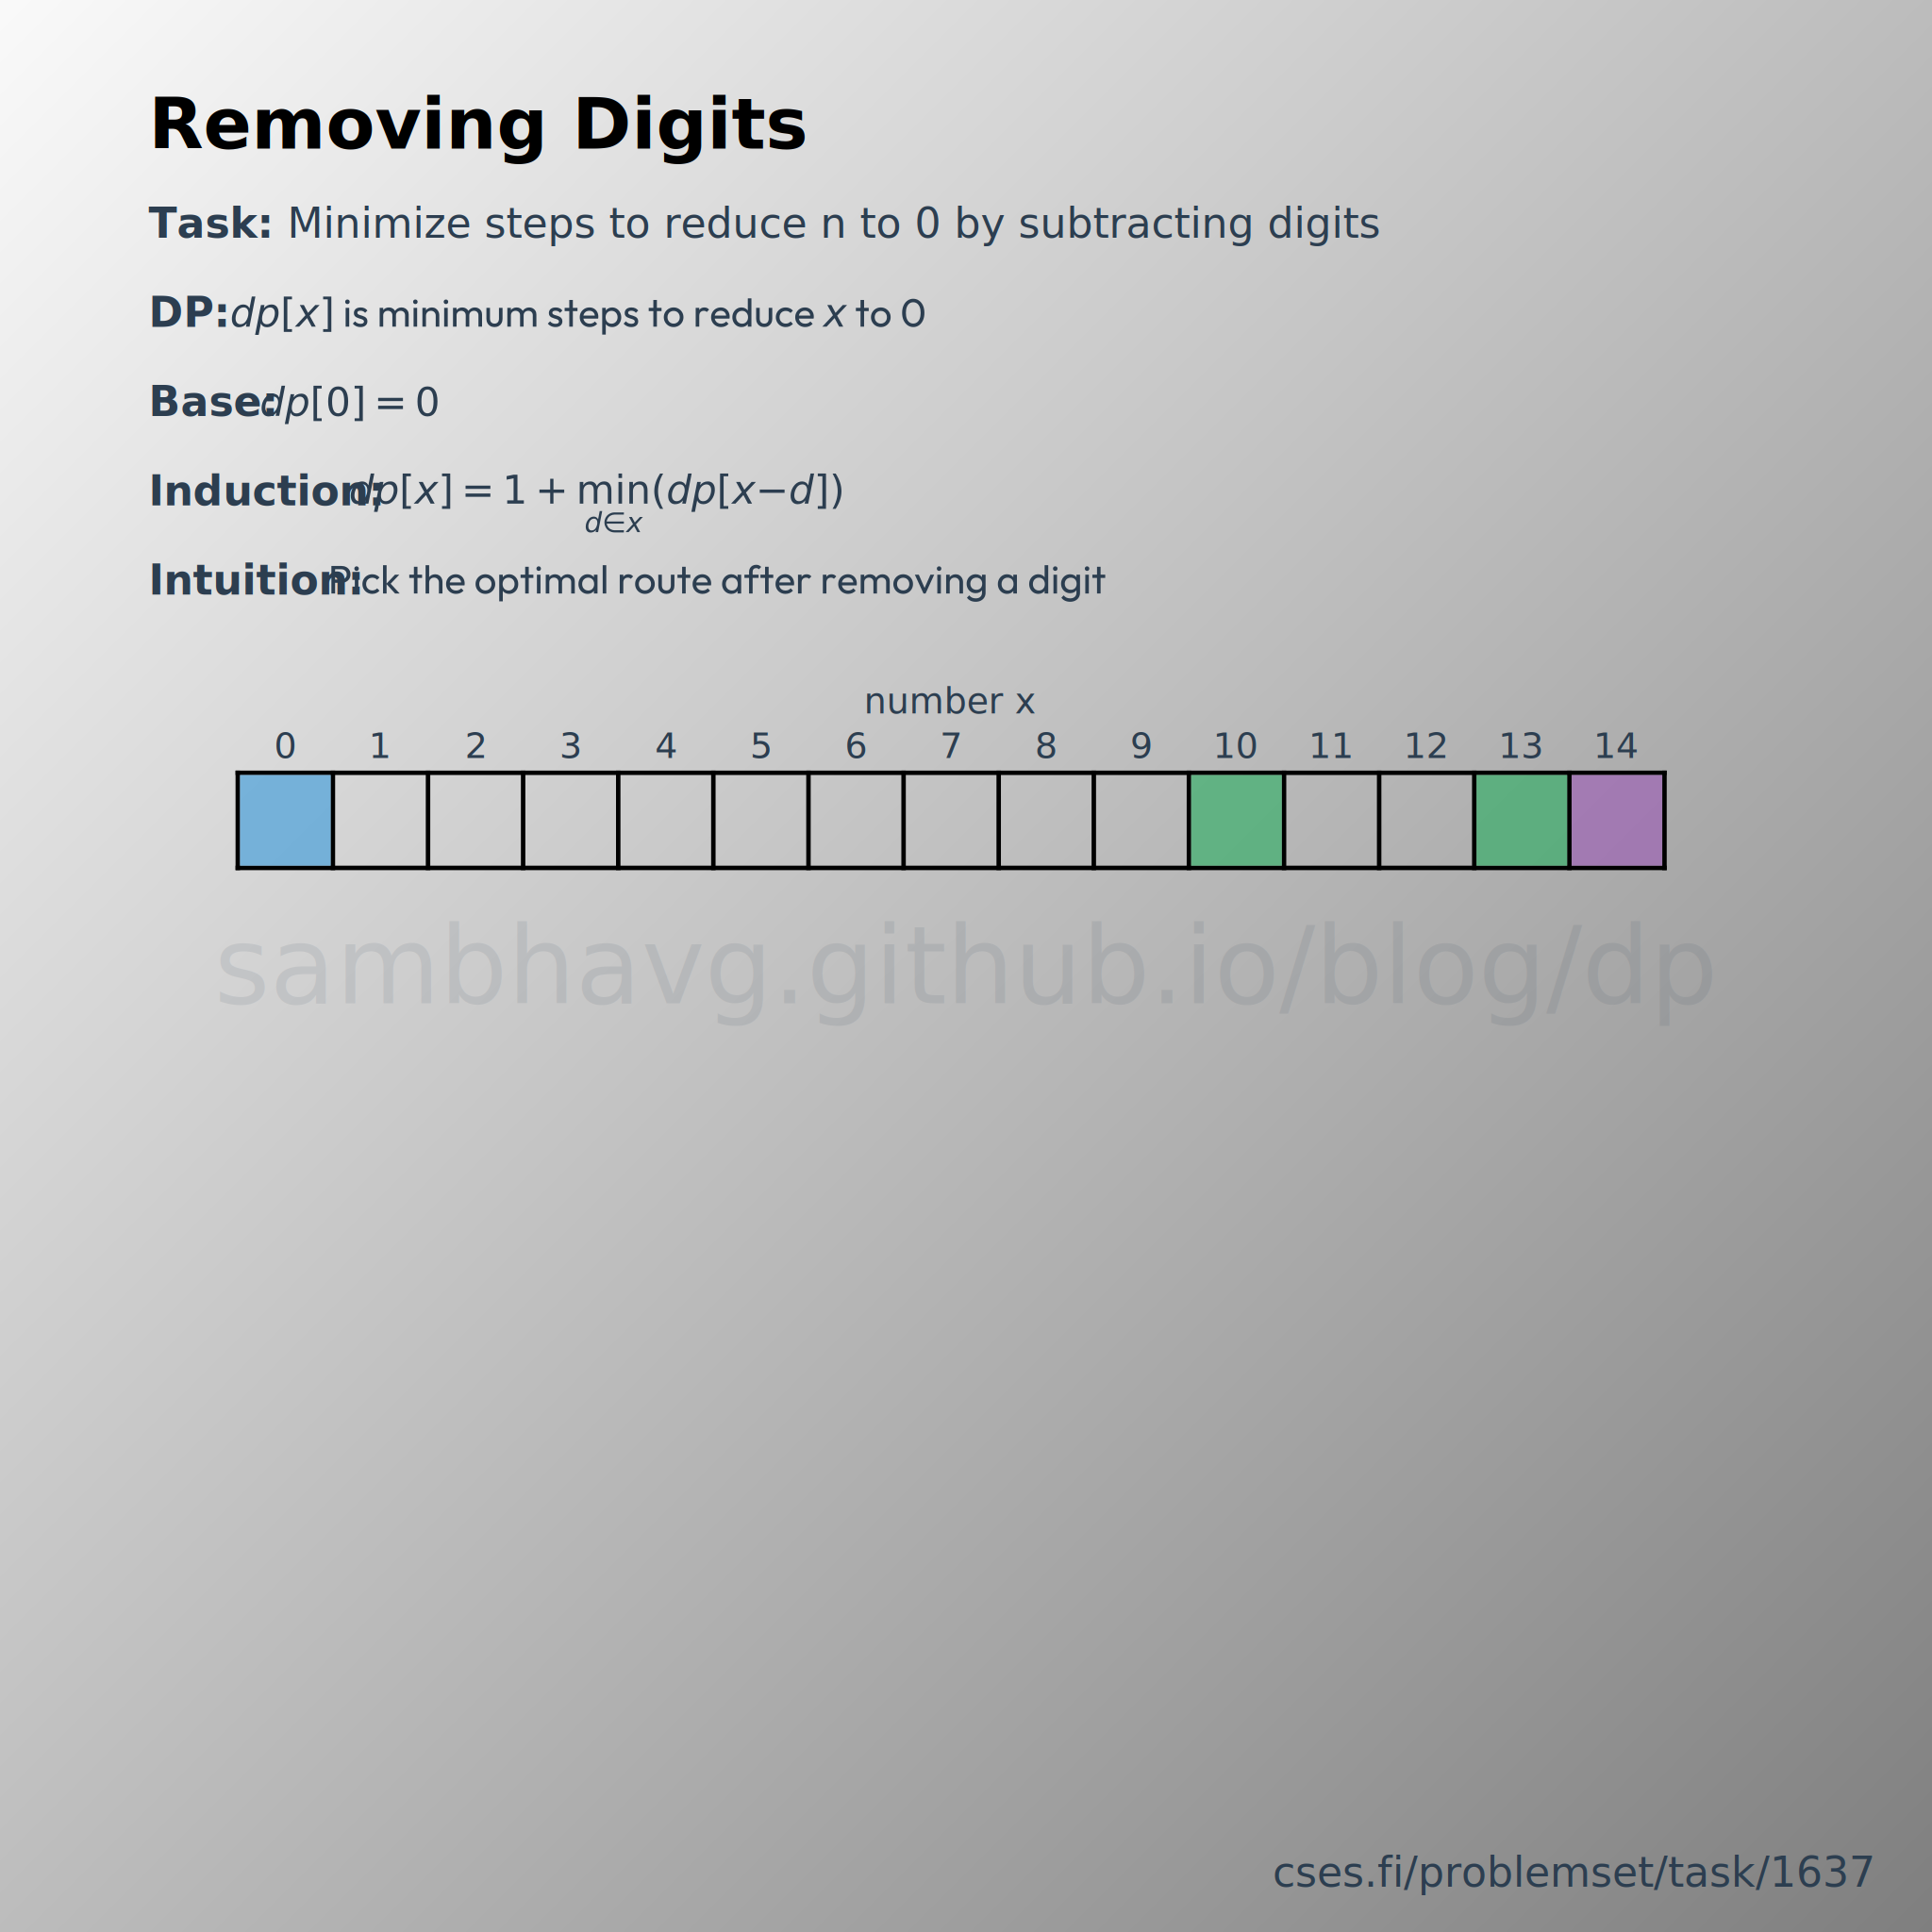

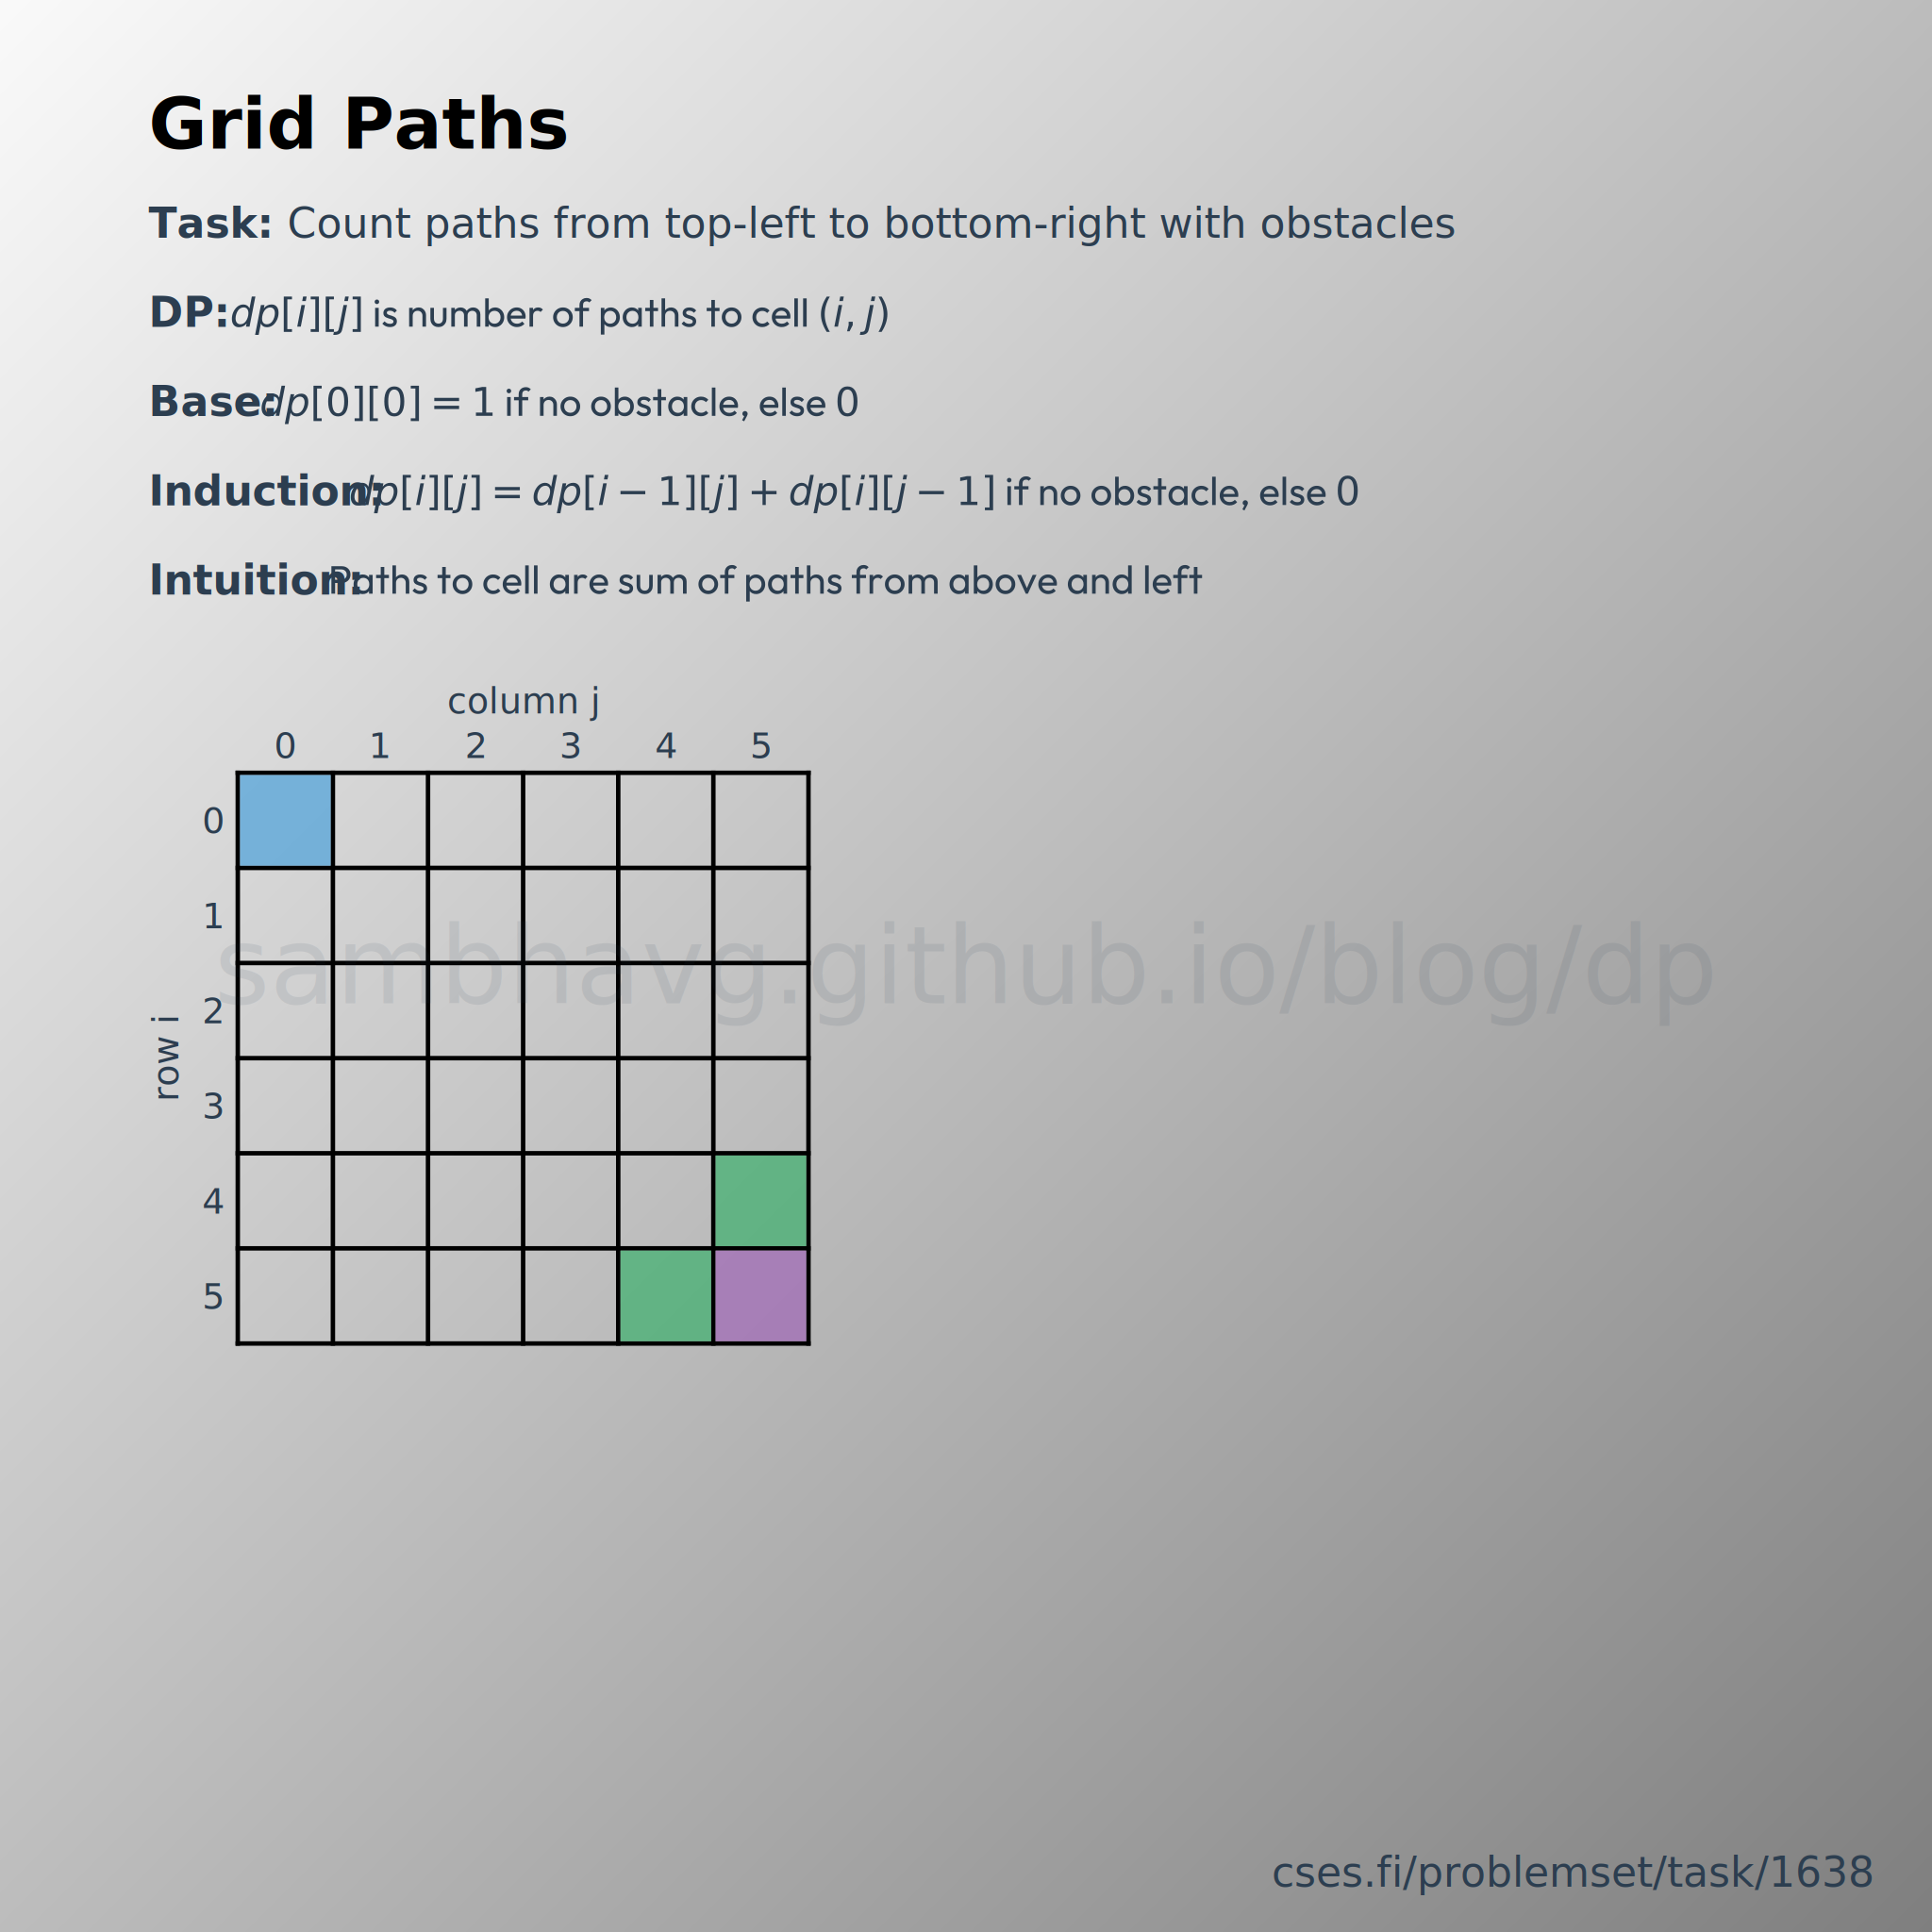

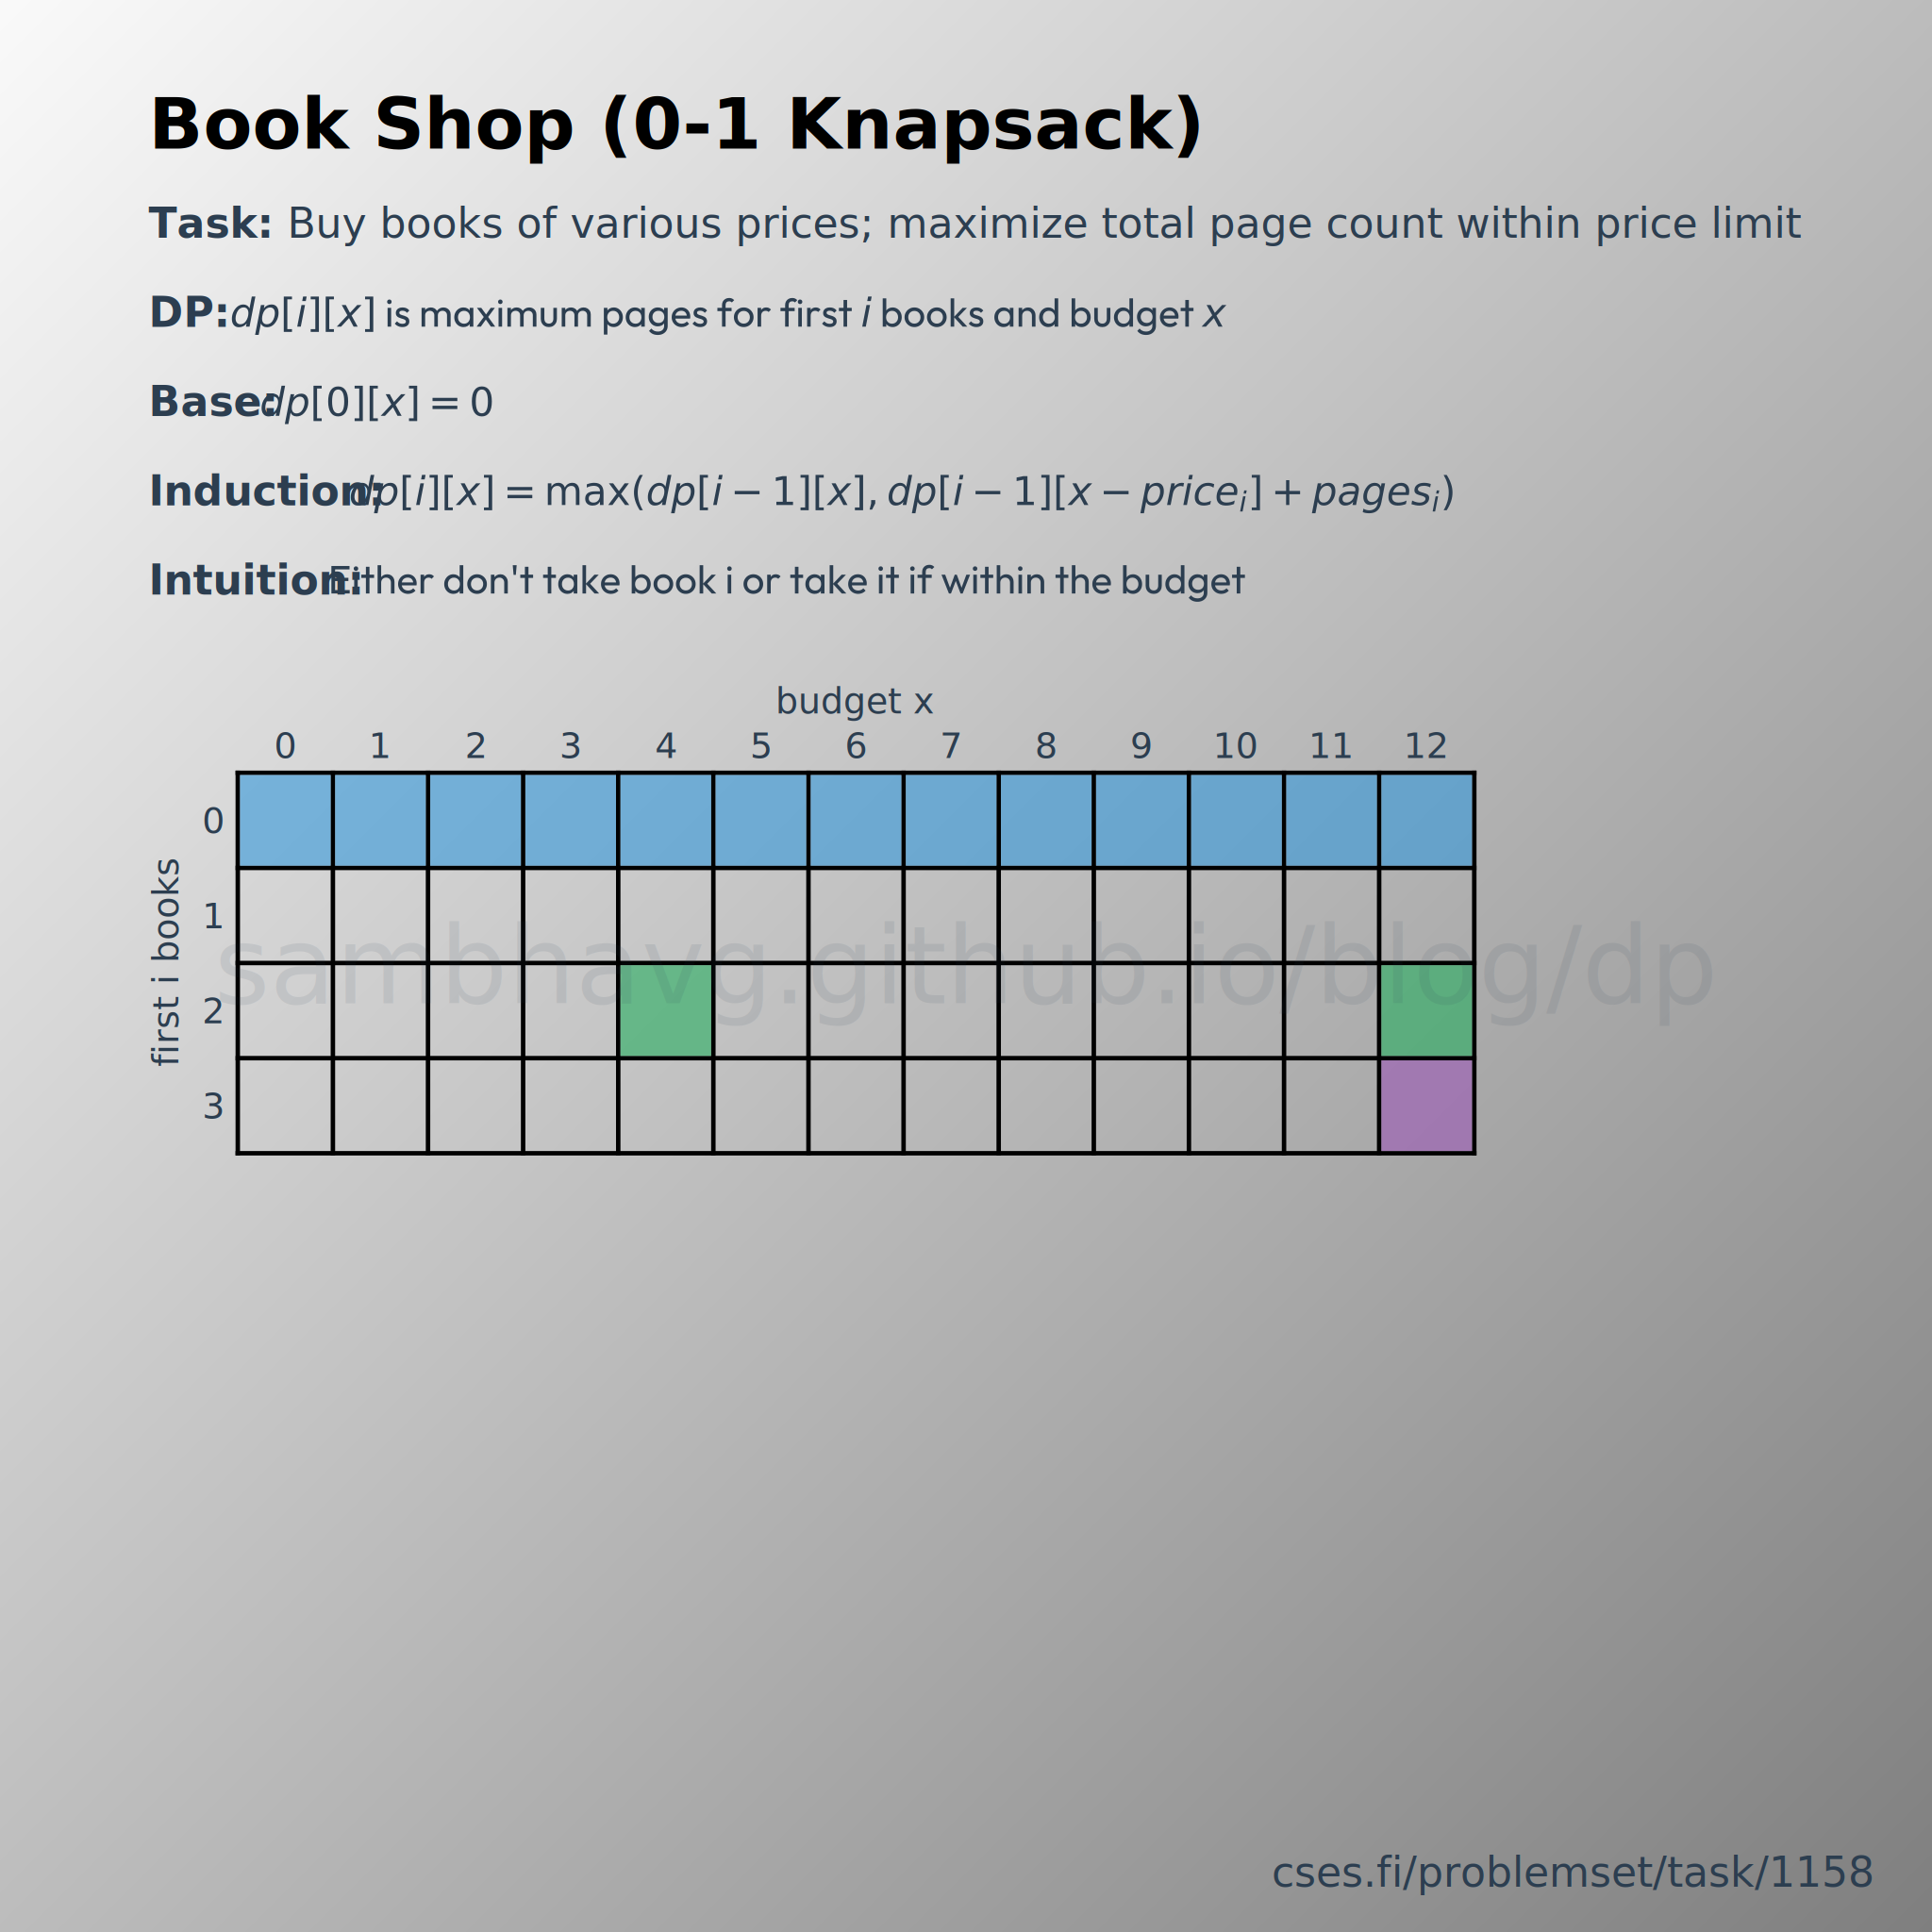

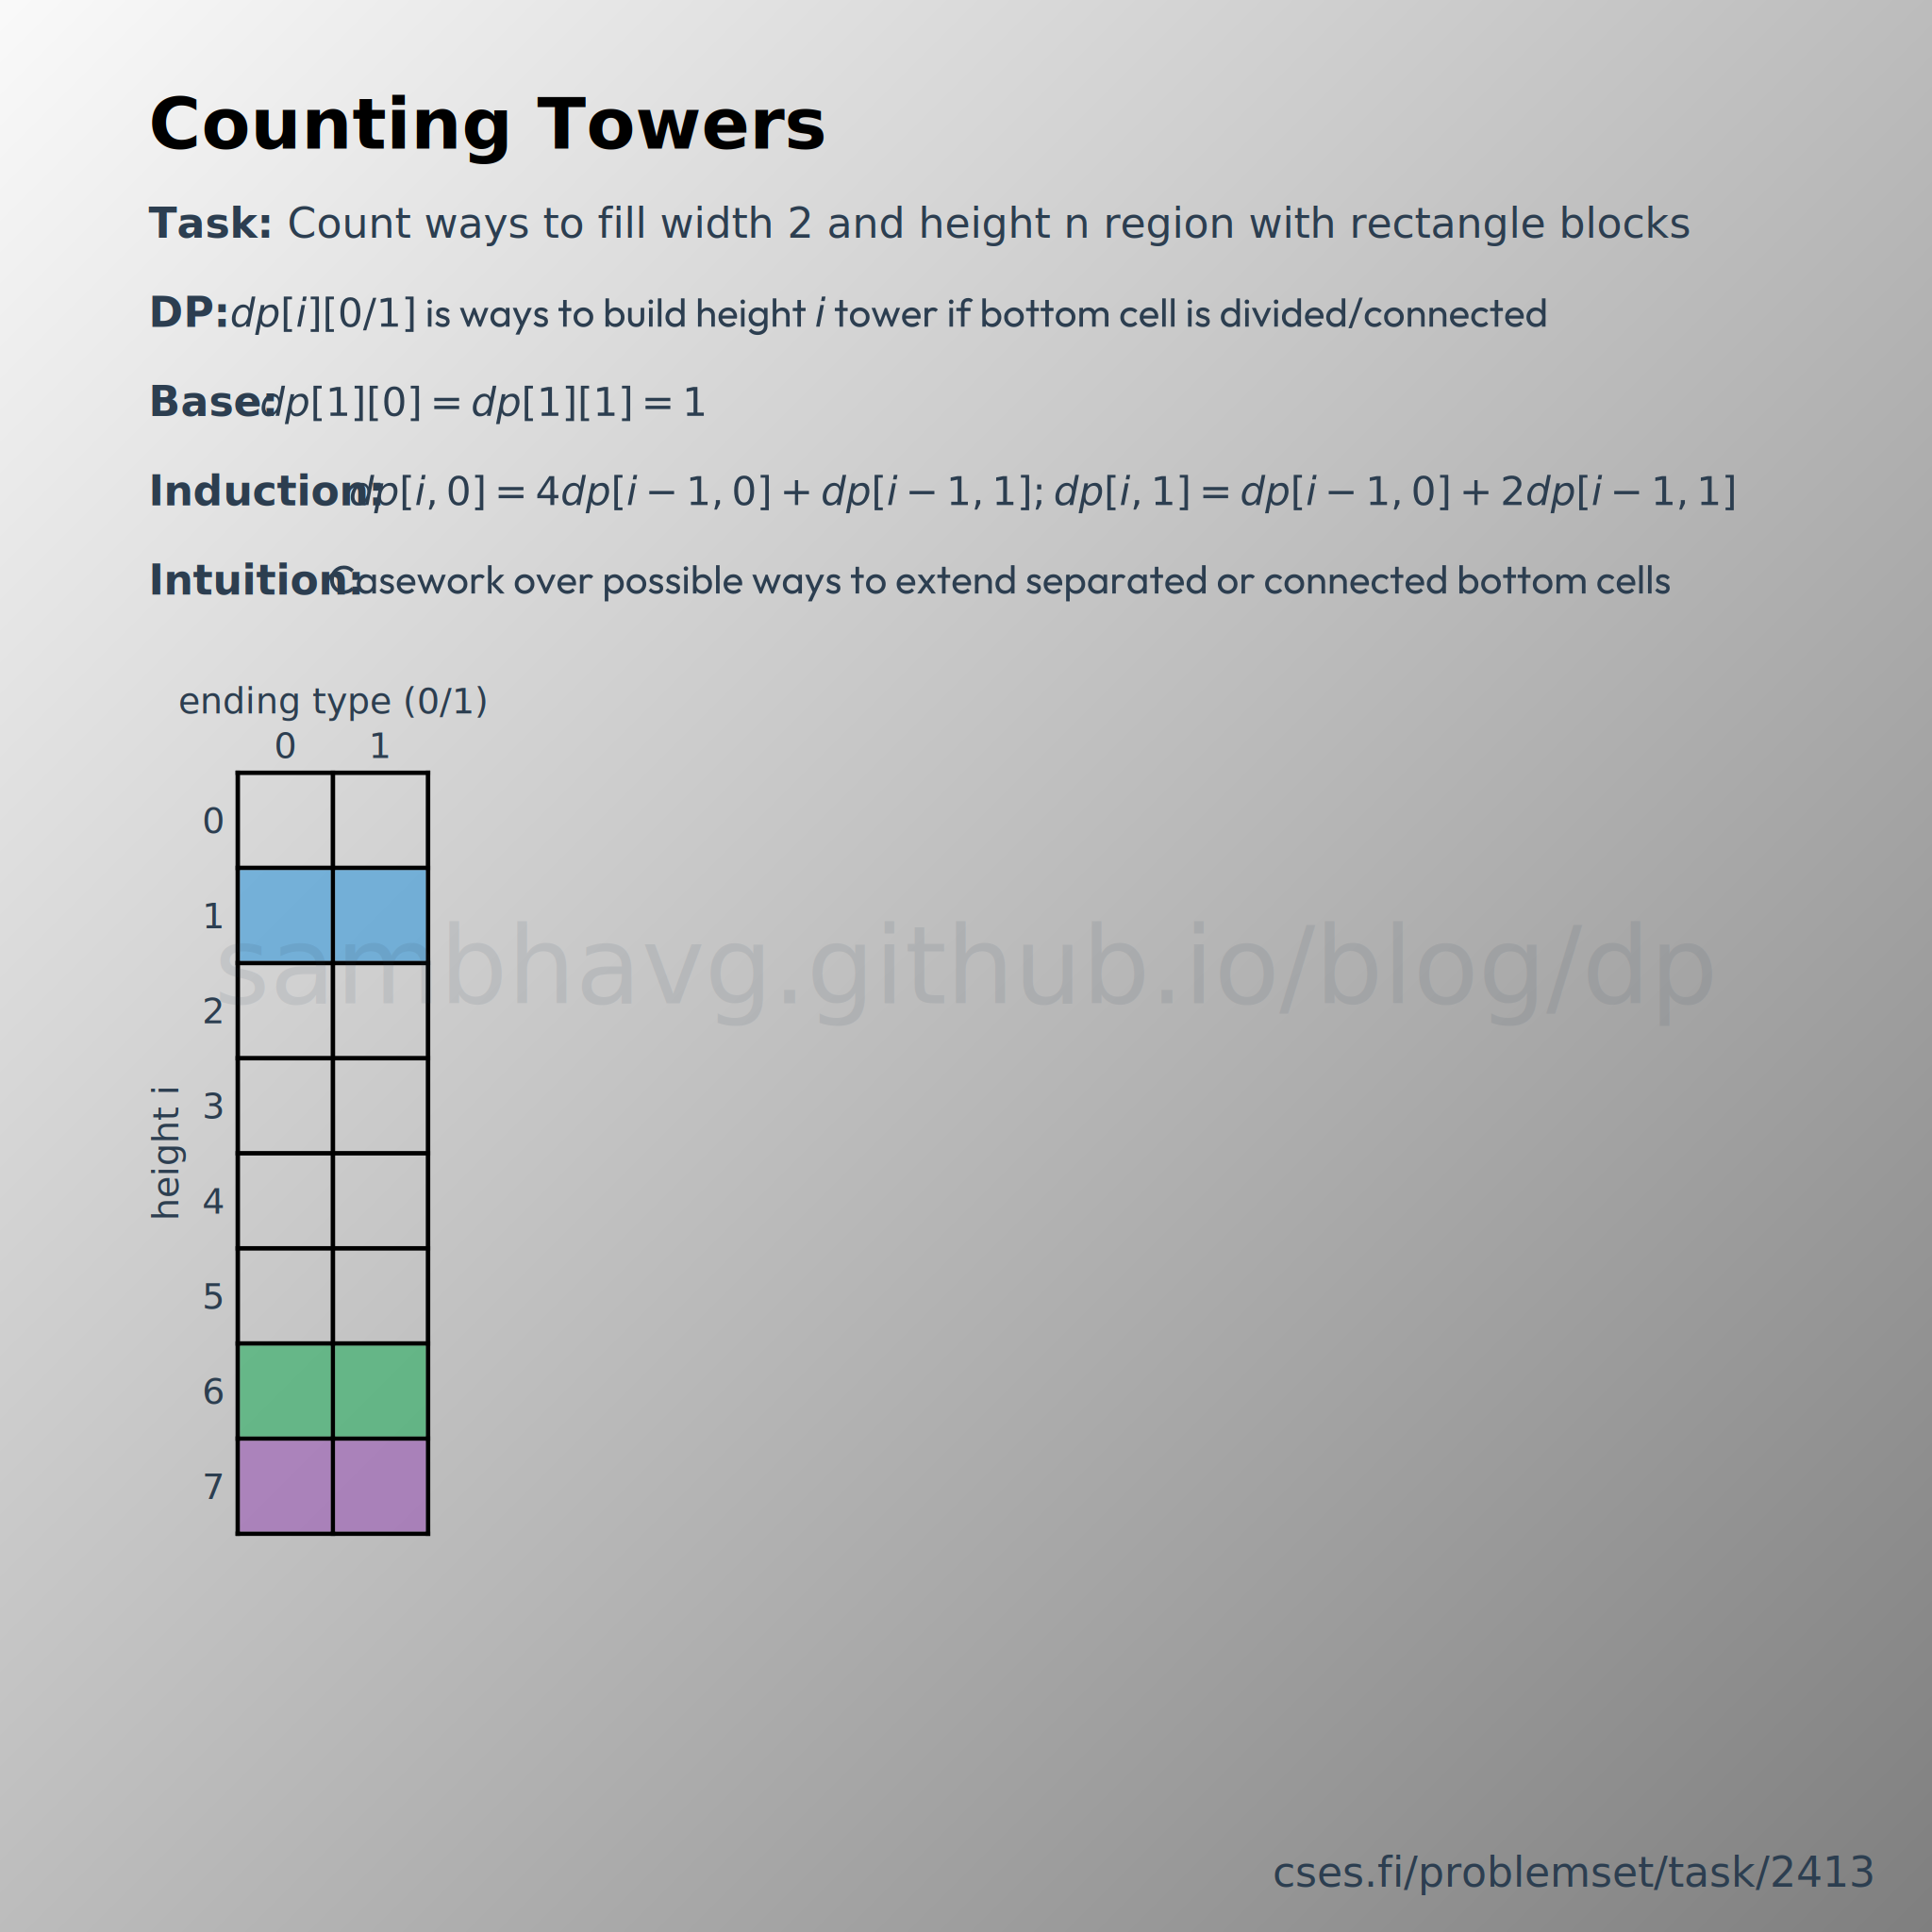

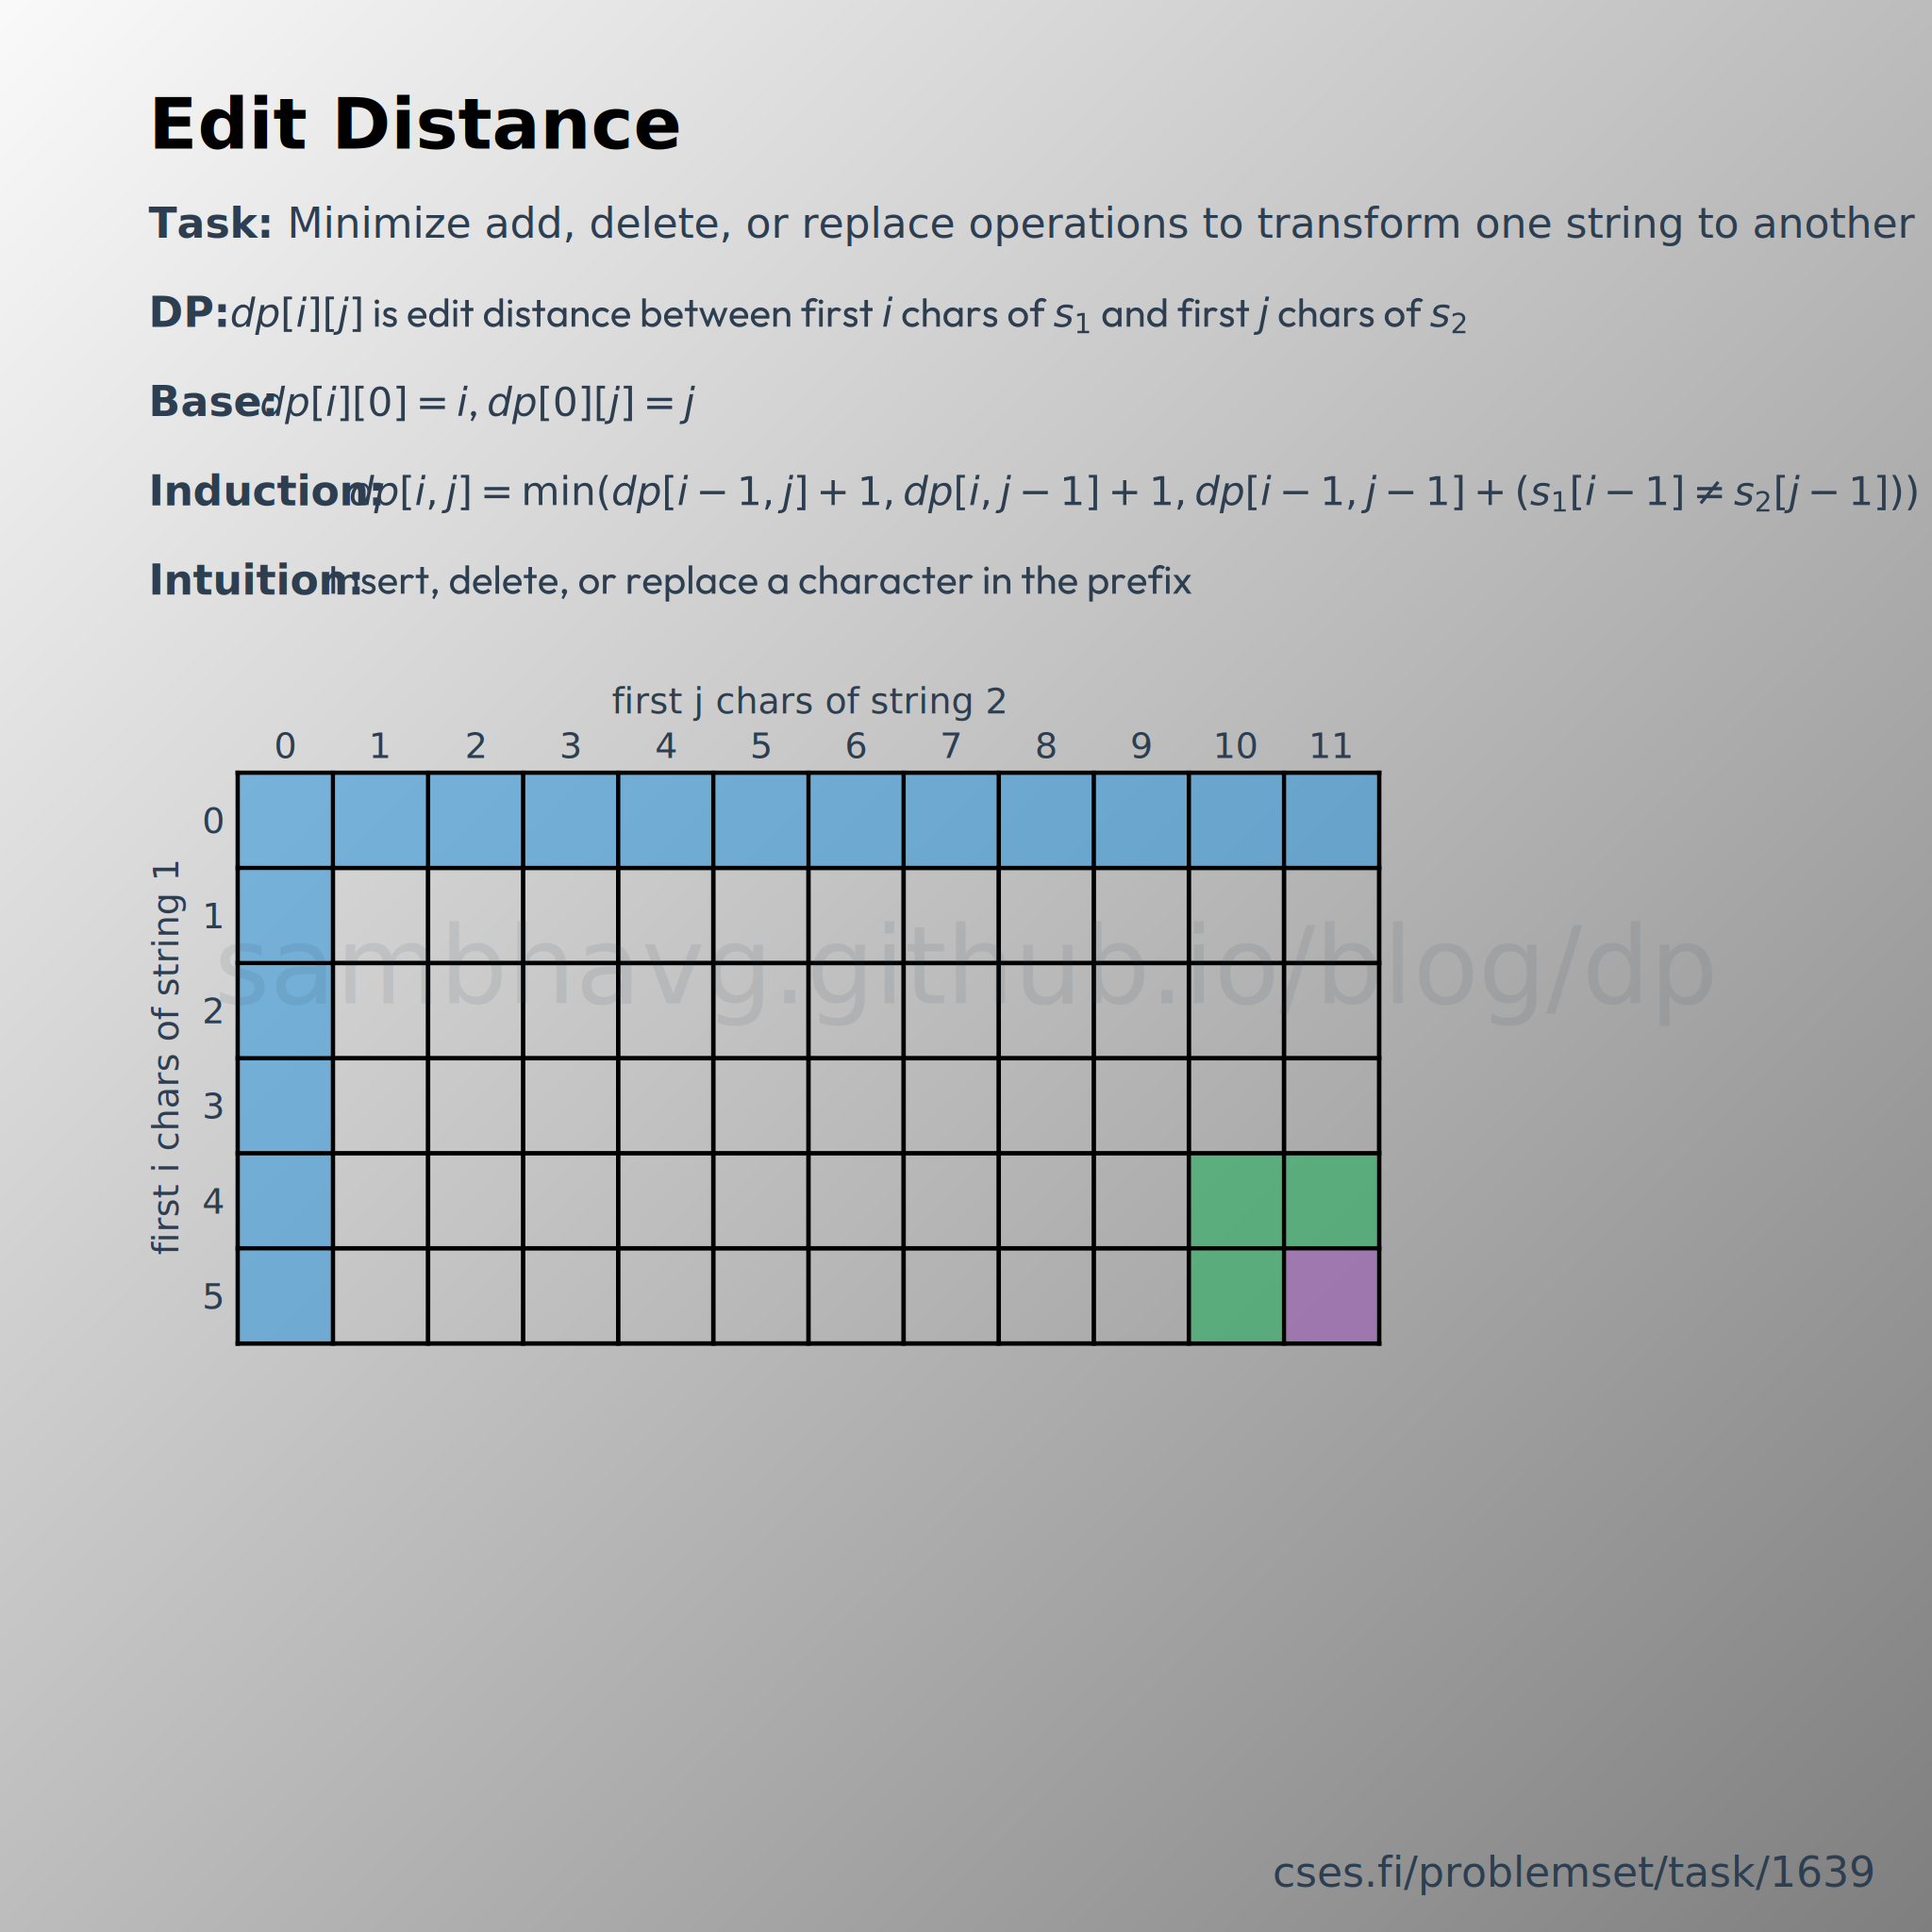

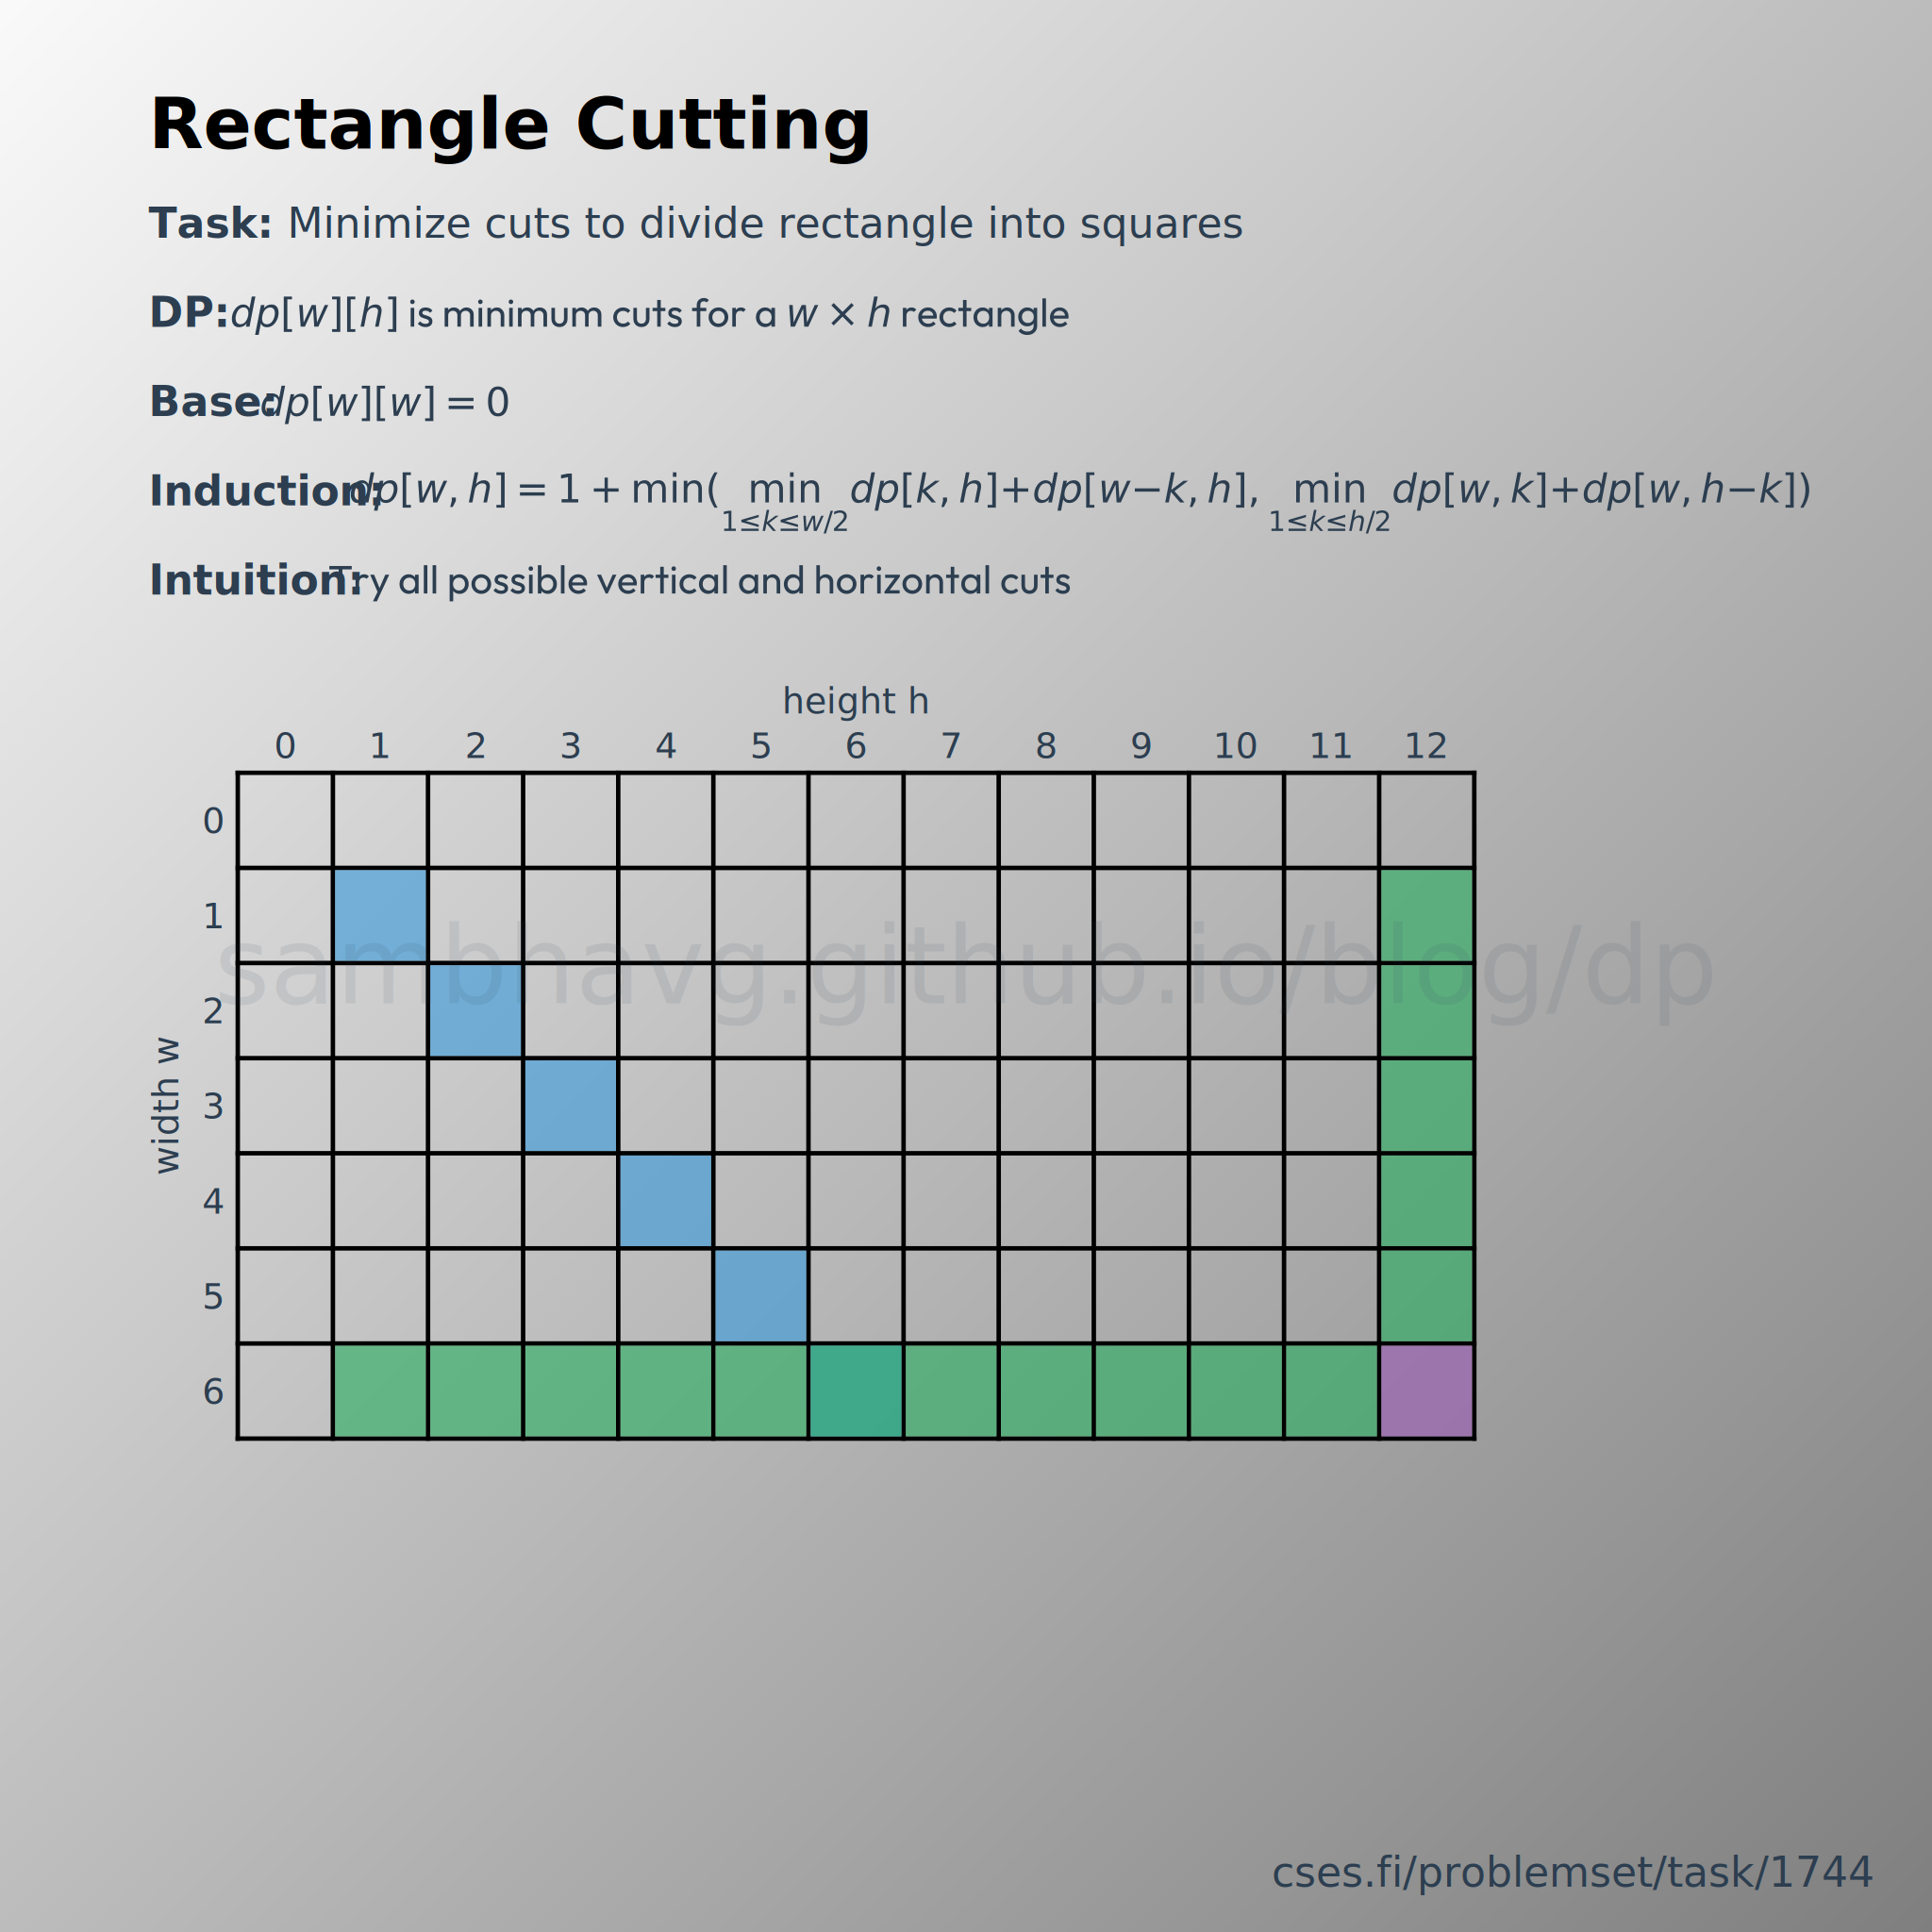

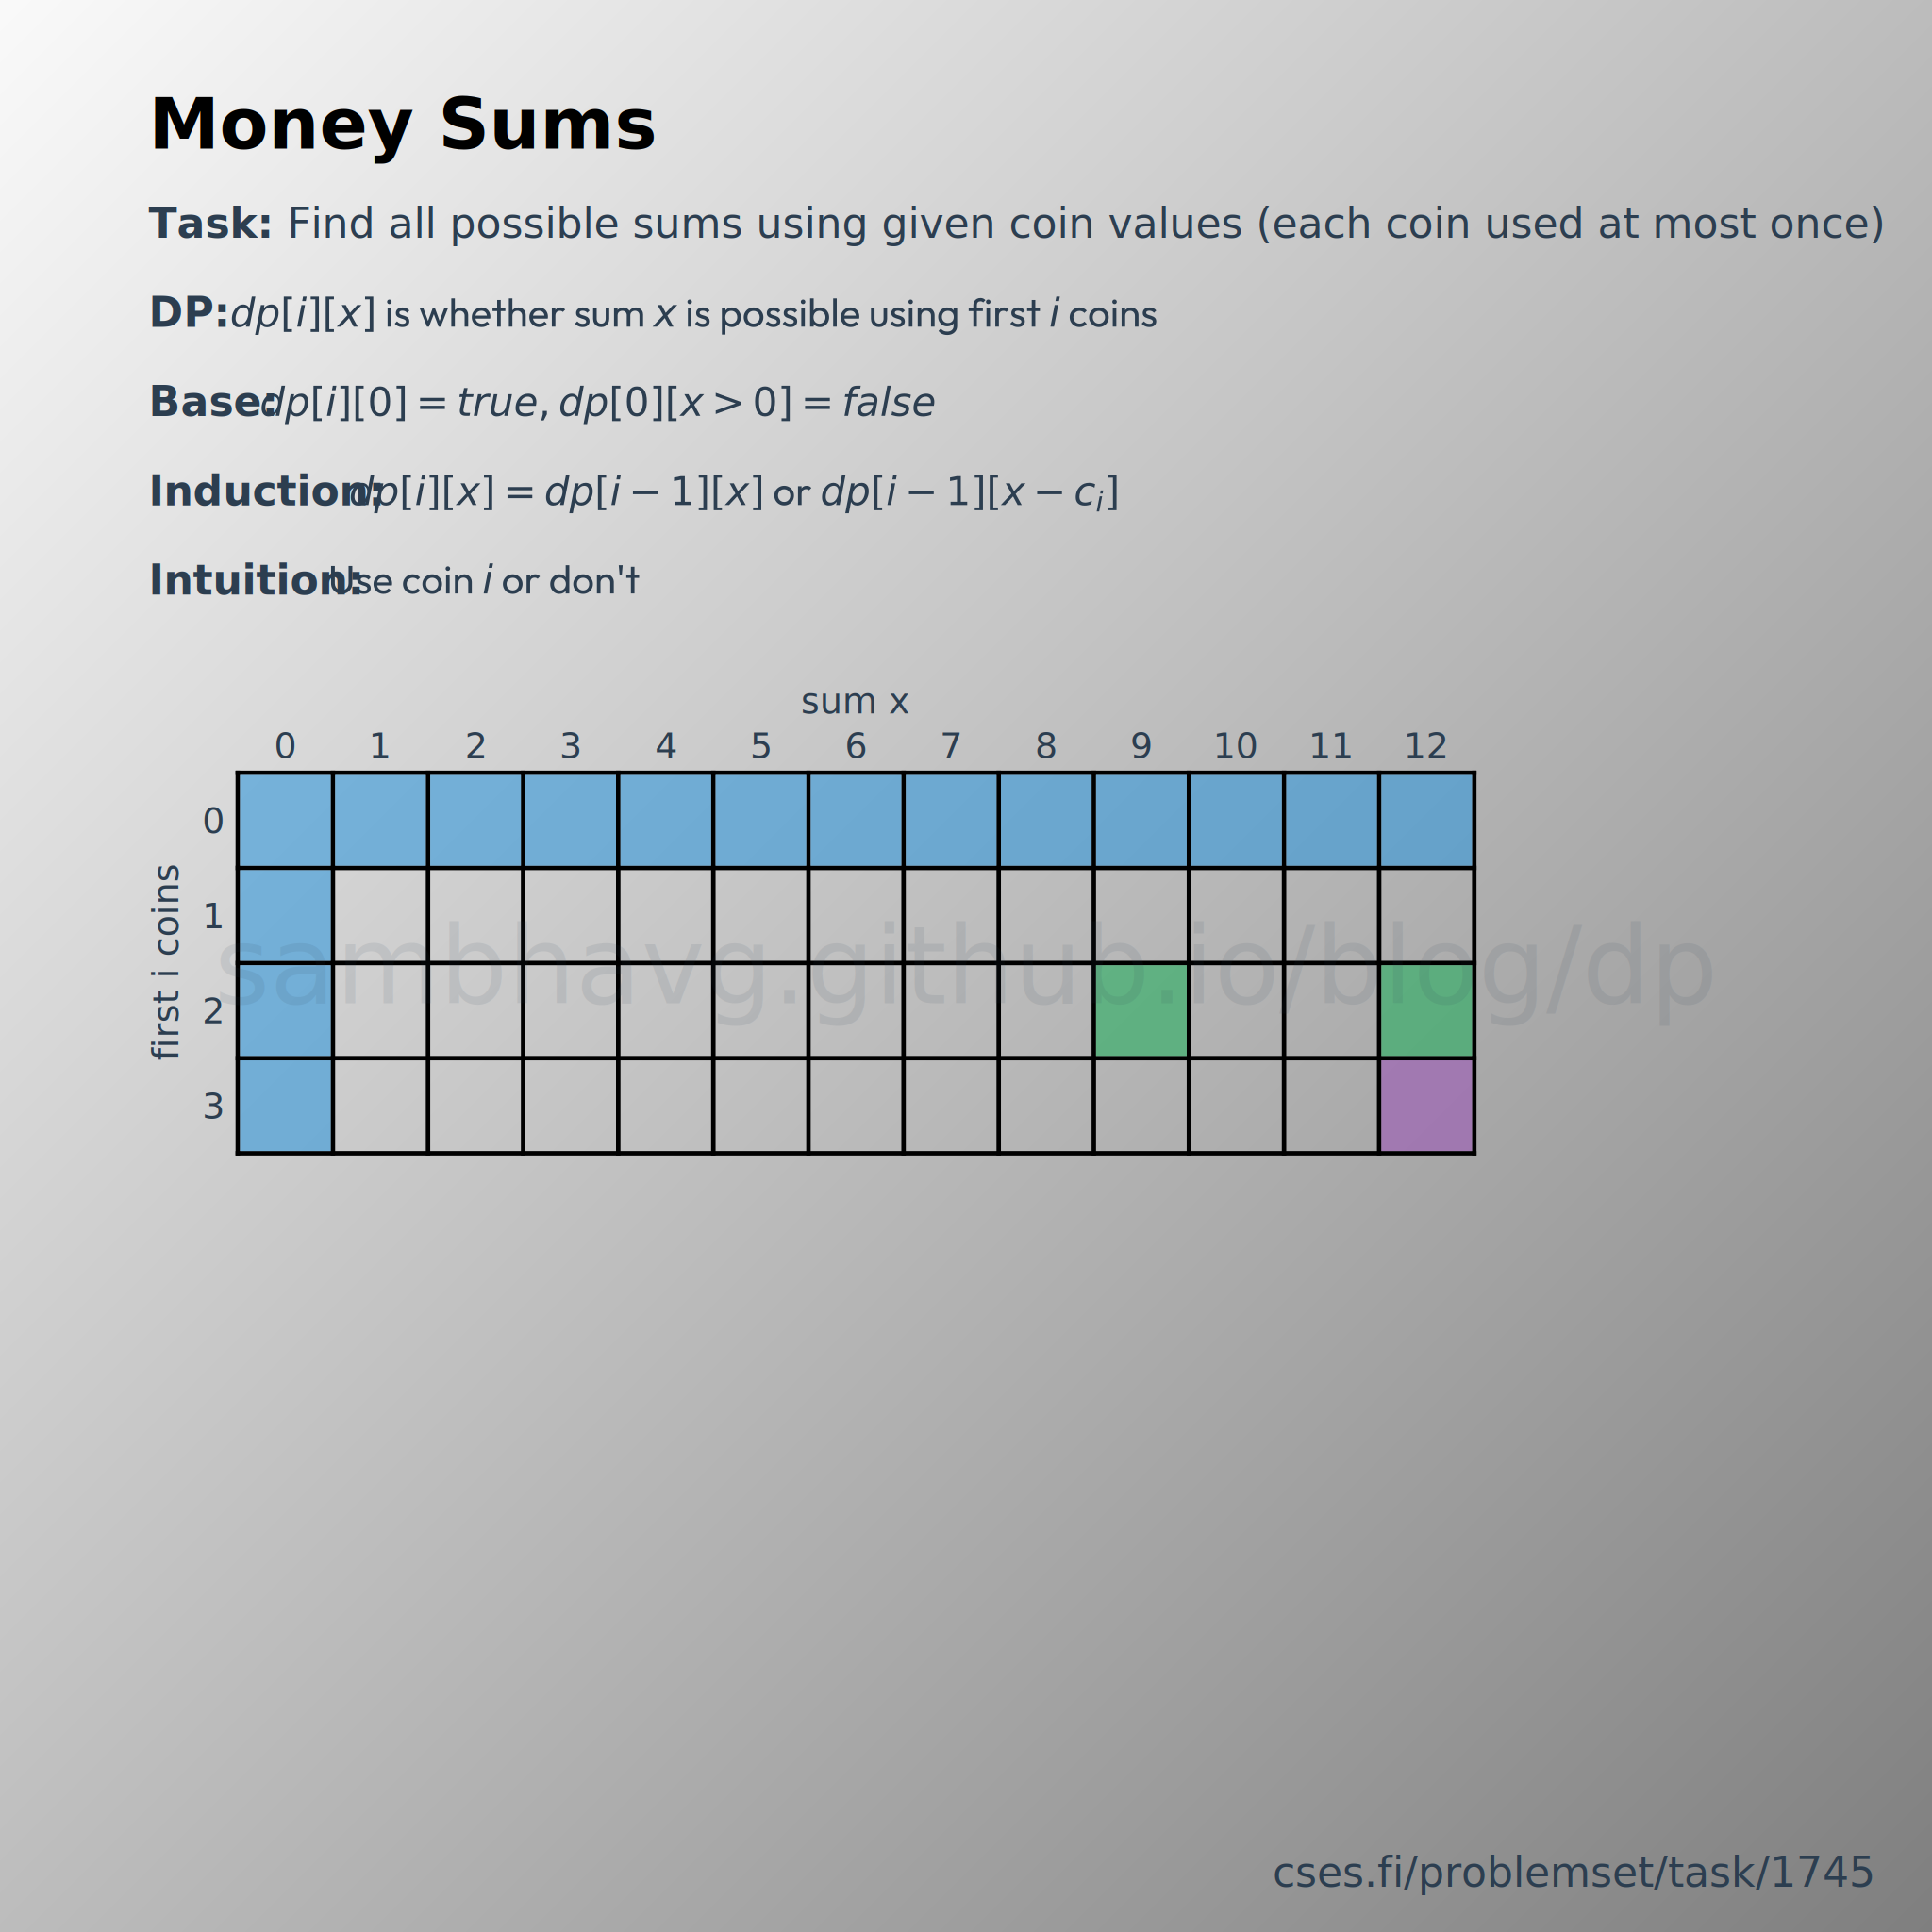

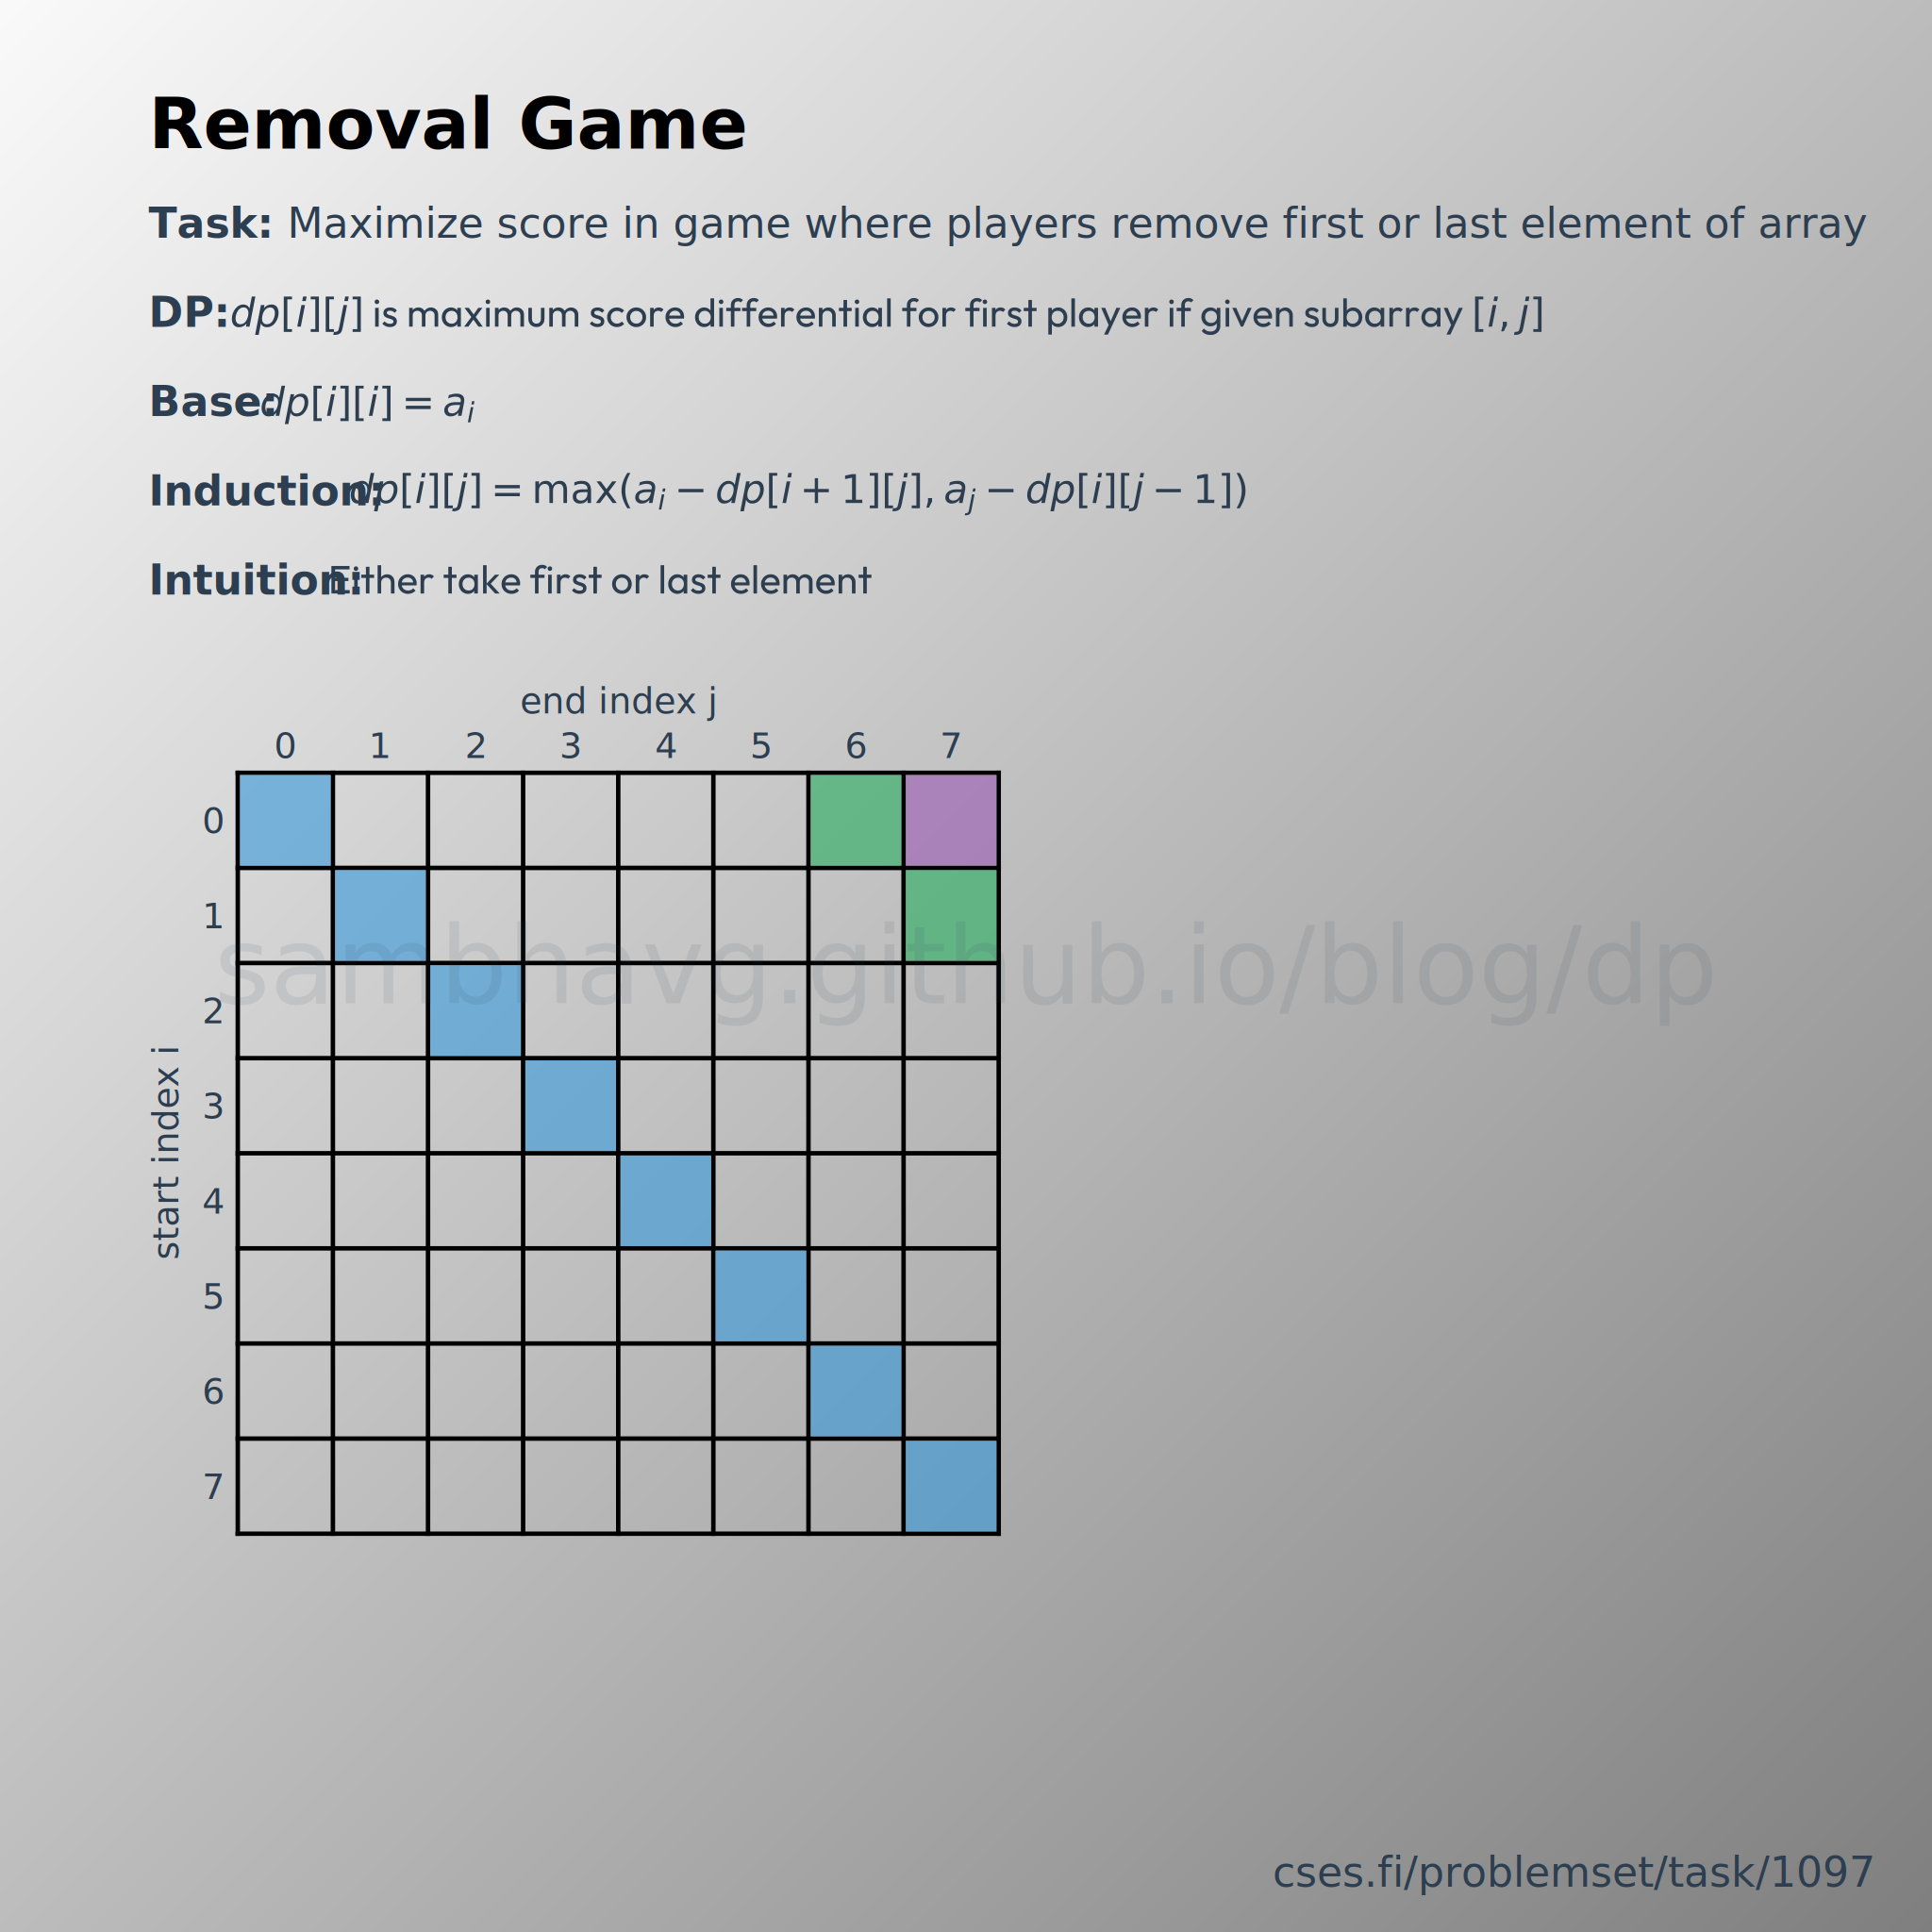

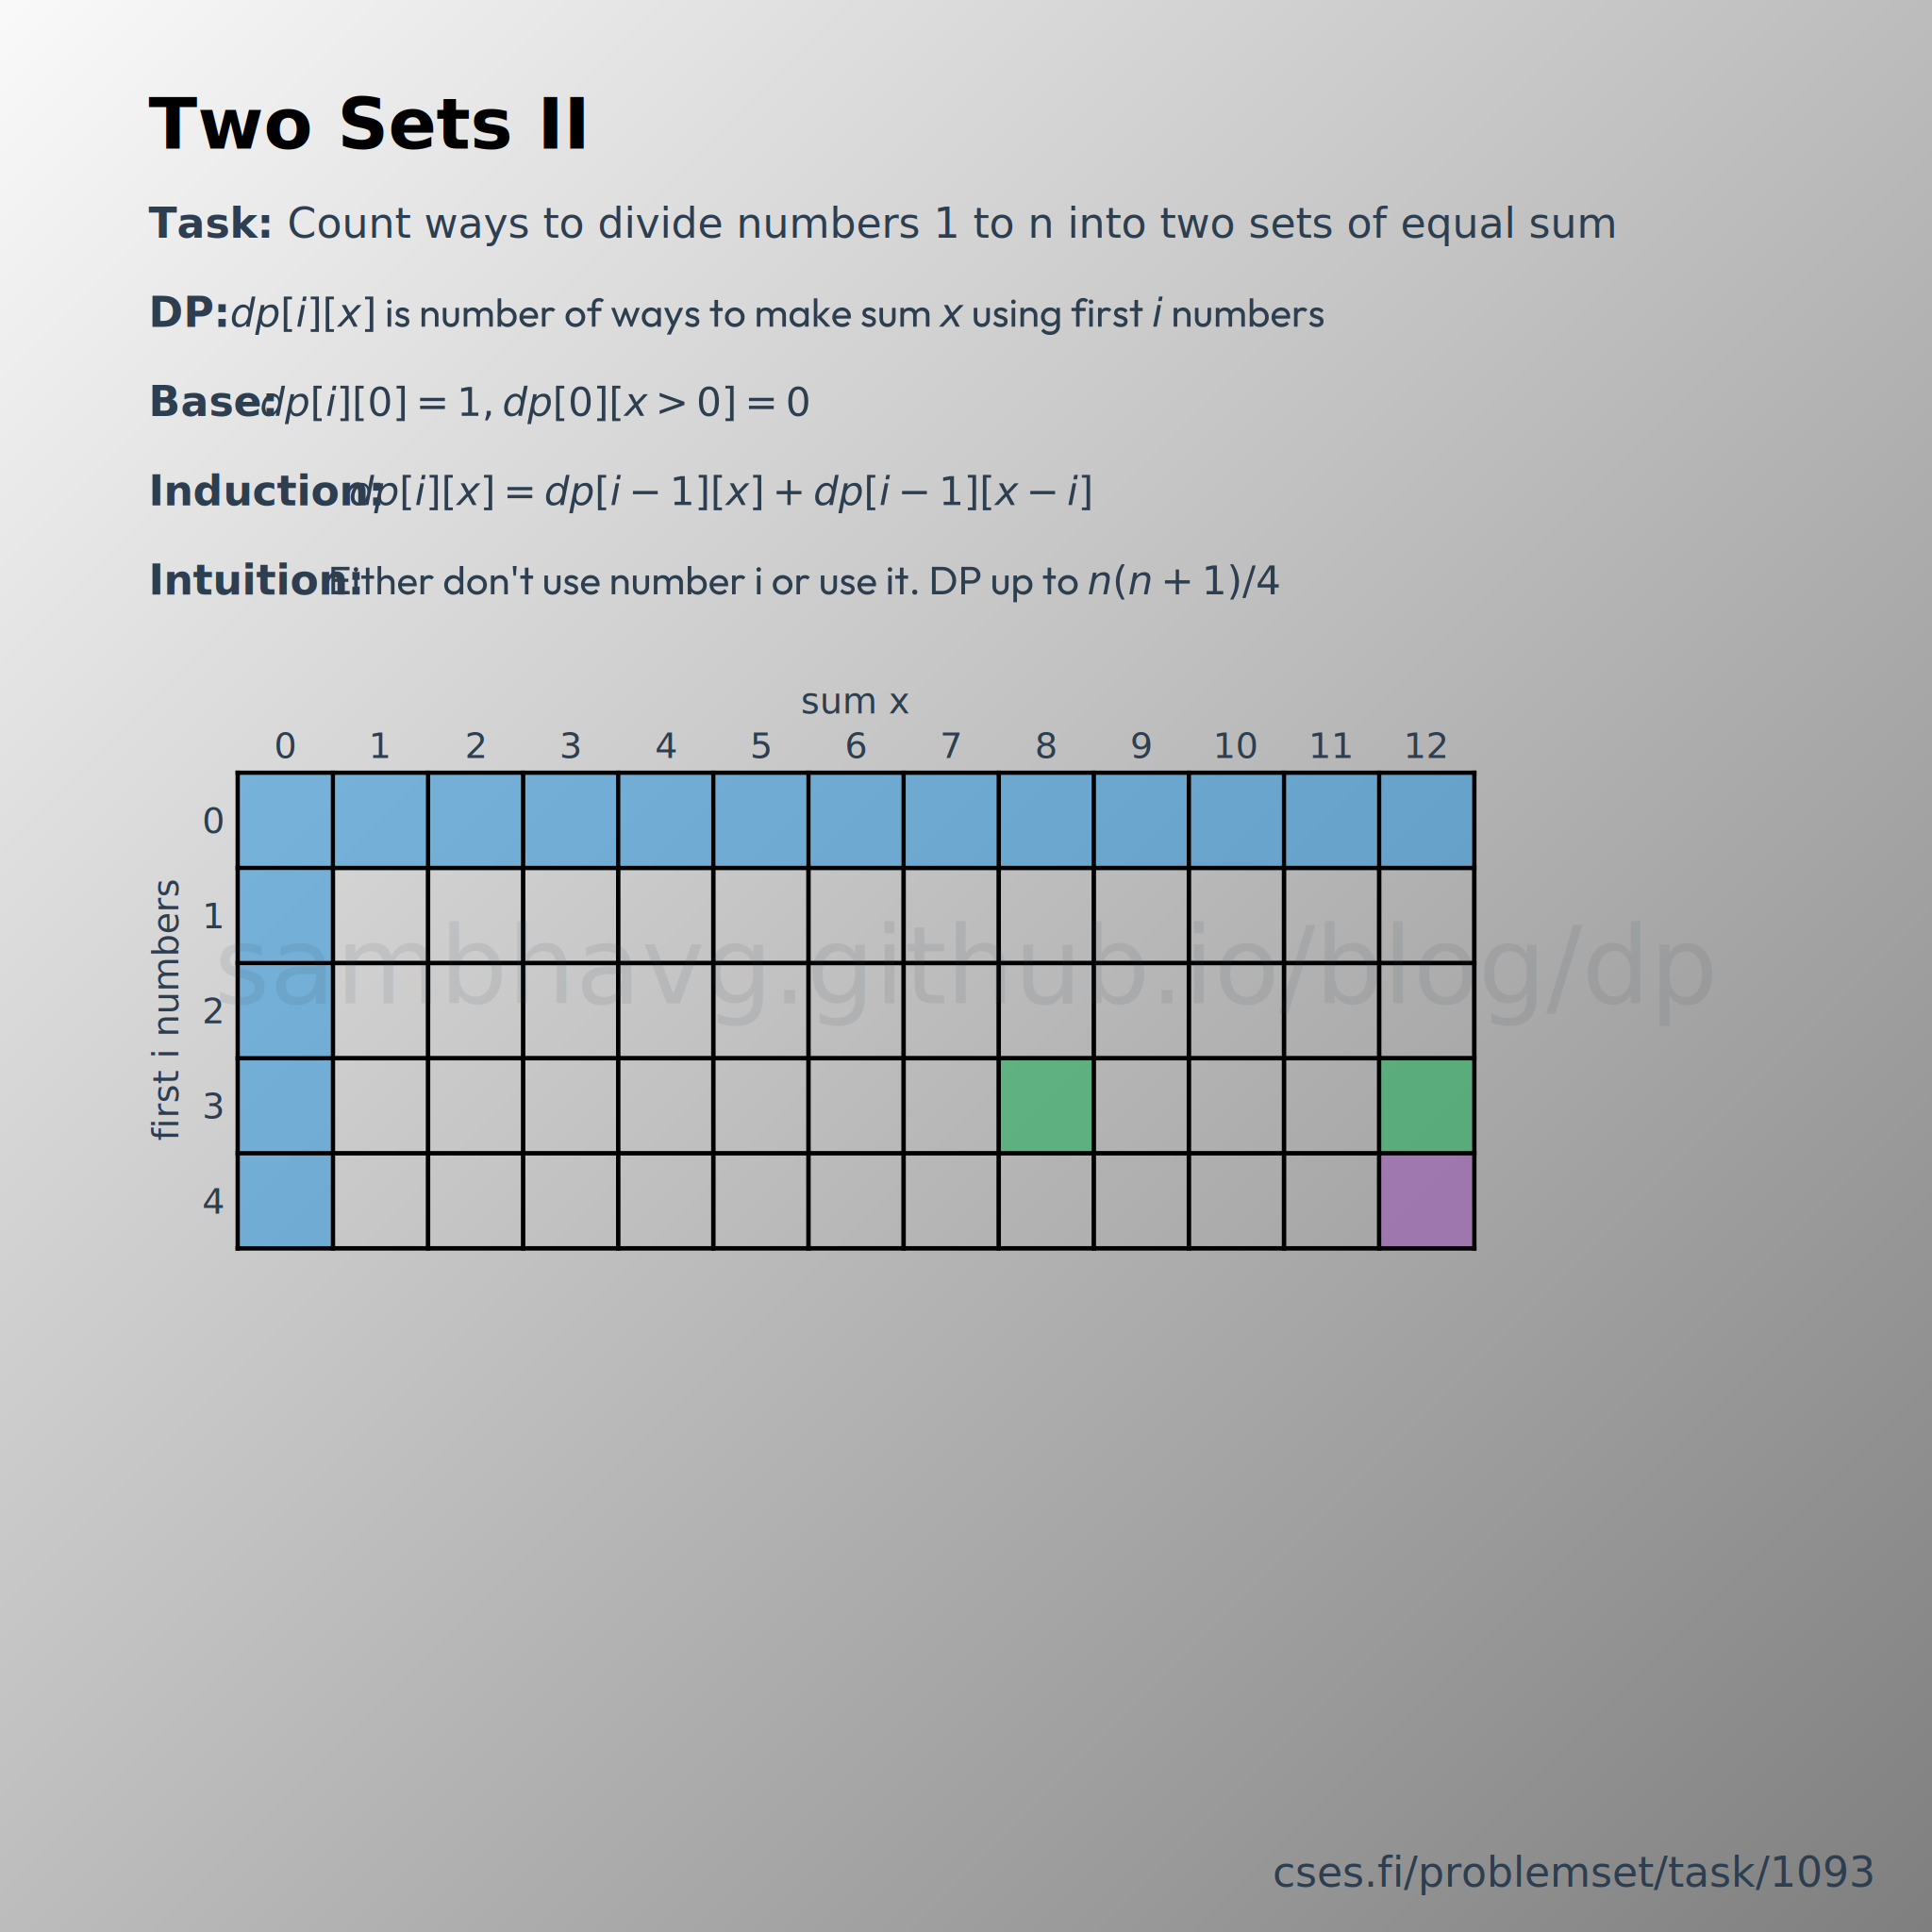

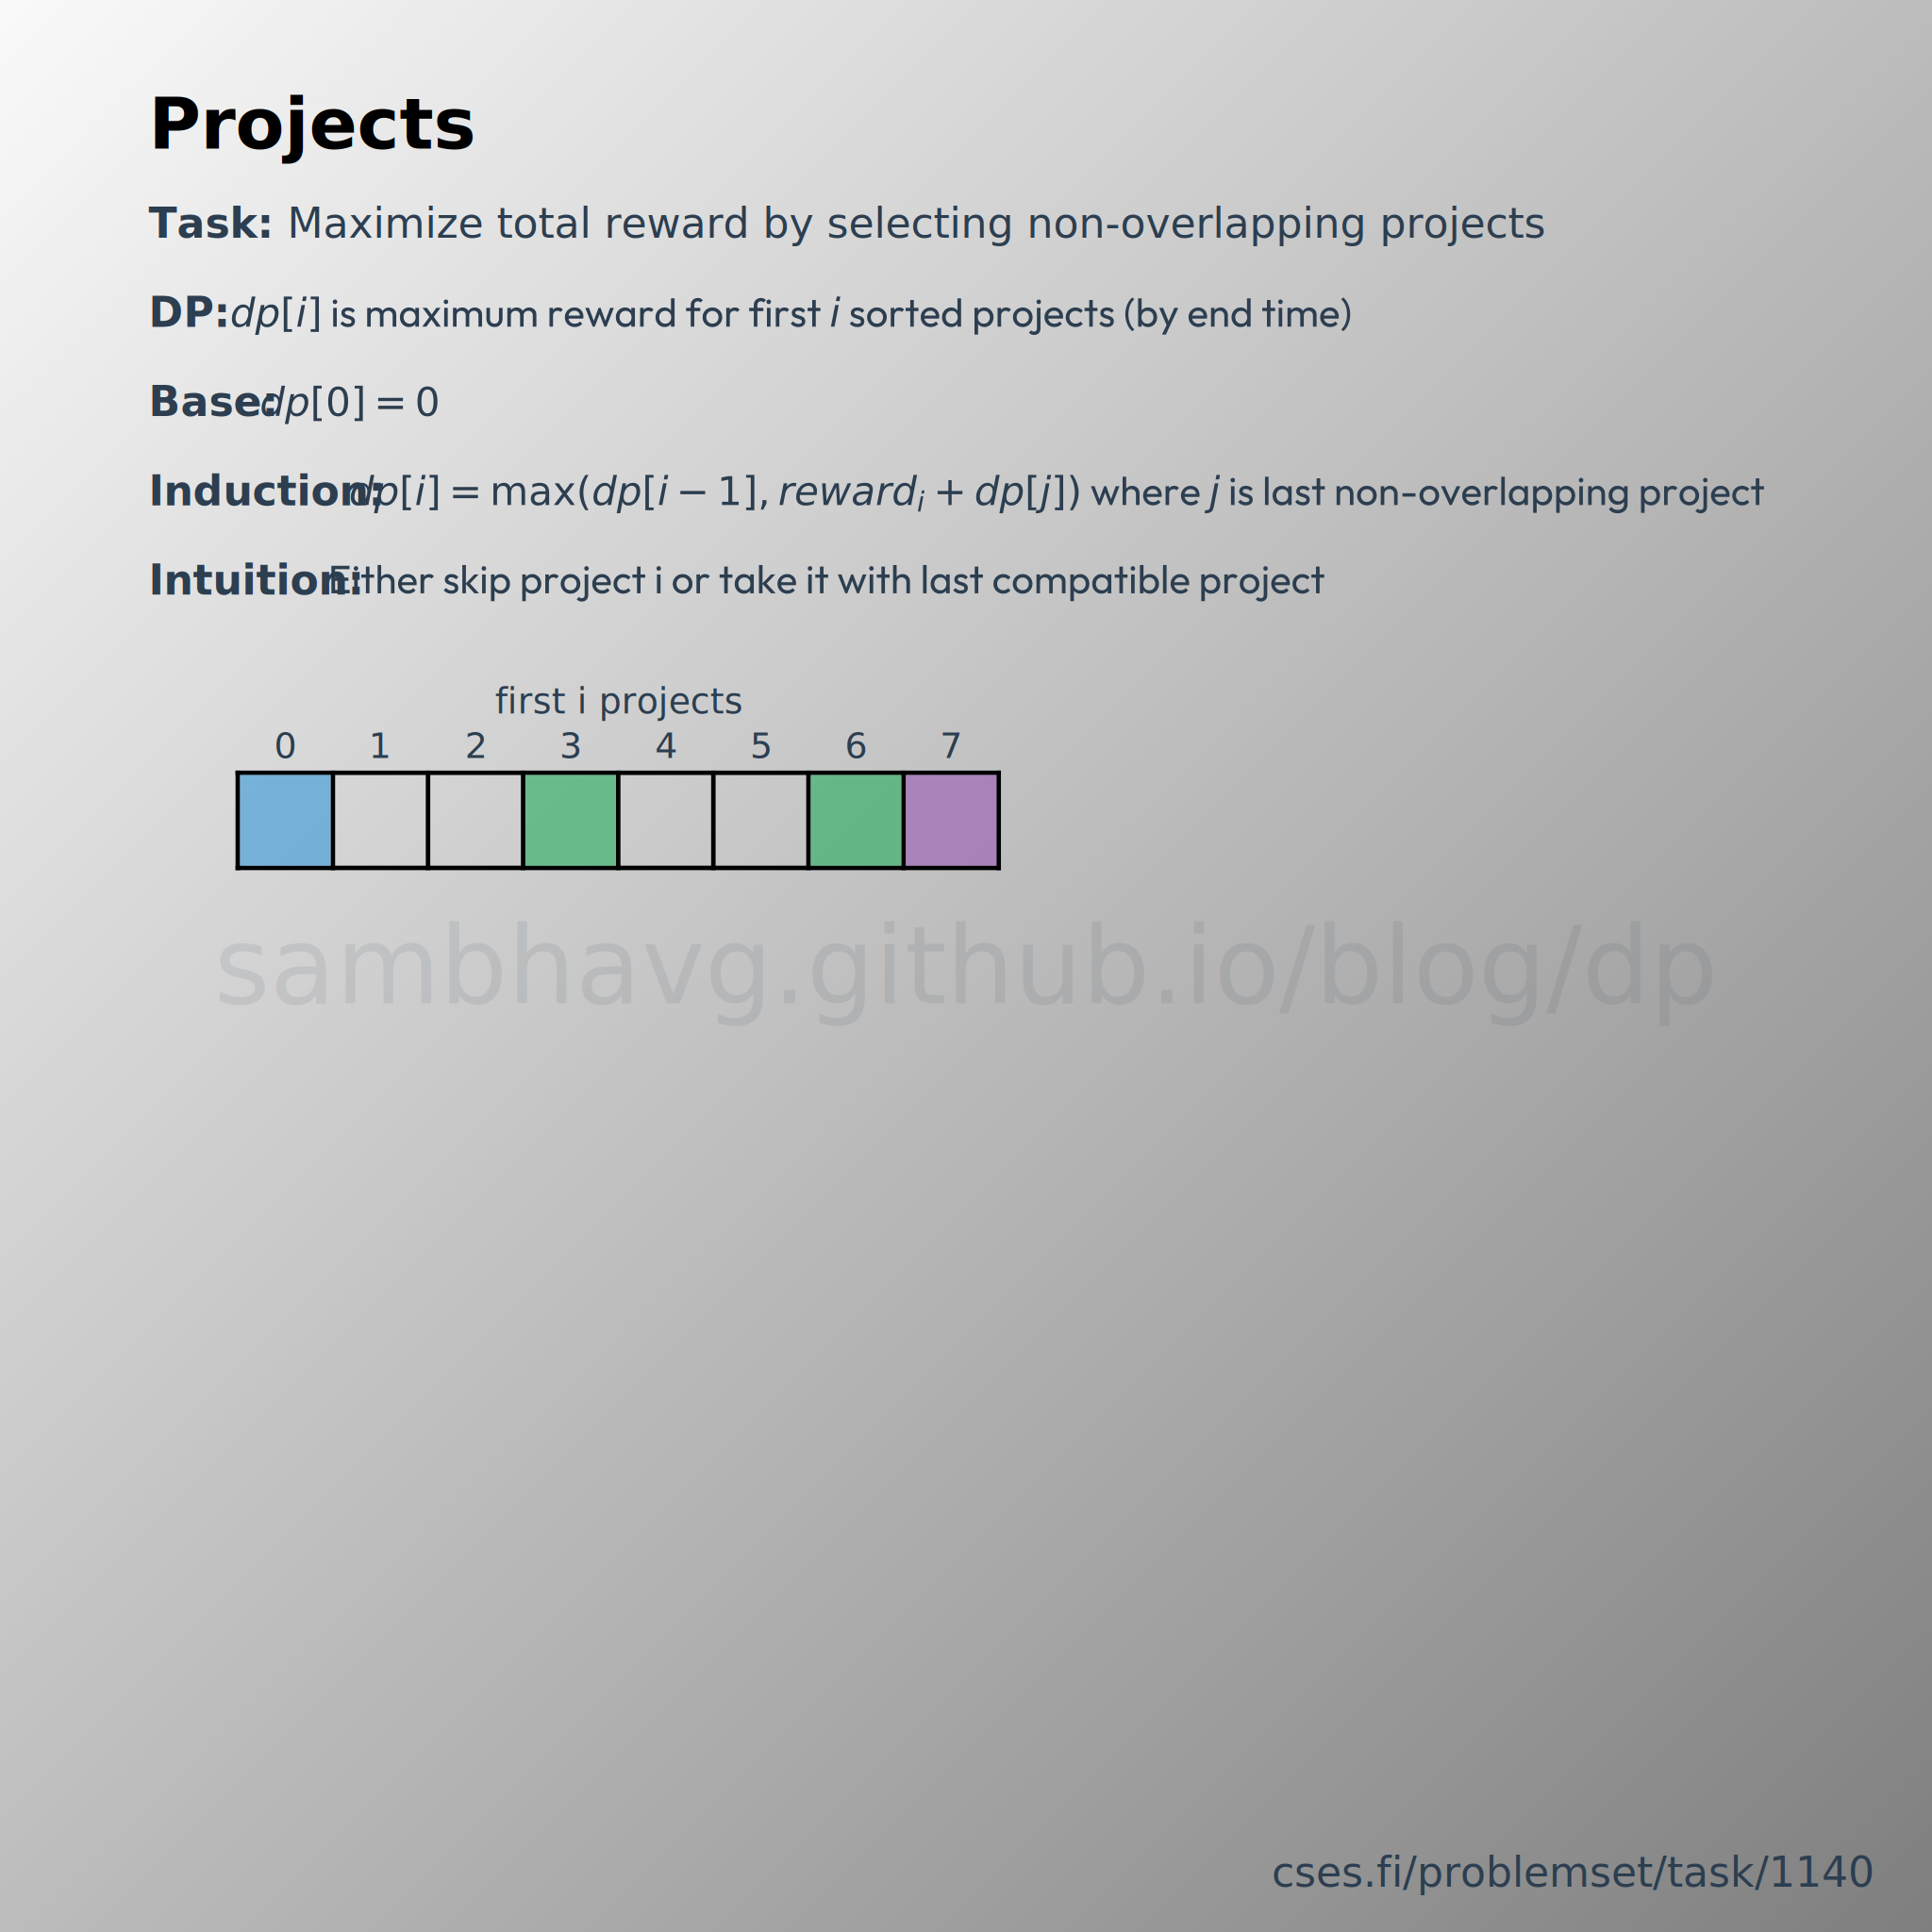

In [112]:
from IPython.display import SVG
from cairosvg import svg2png
from wand.api import library
import wand.image
import wand.color

dp_problems = [
    {
        "title": "Dice Combinations",
        "link": "cses.fi/problemset/task/1633",
        "task": "Construct n with ordered dice rolls",
        "dp": "$dp[x]$ is the number of ways to construct $x$",
        "base_case": "$dp = [1, 1, 2, 4, 8, 16, 32]$",
        "induction_step": r"$dp[x] = \sum_{i=x-6}^{x-1} dp[i]$",
        "intuition": "The last roll can be any of 1, 2, 3, 4, 5, or 6",
        "rows": 1,
        "cols": 15,
        "each_row": "",
        "each_col": "sum x",
        "base_cases": [(0, i) for i in range(7)],
        "dependencies": [(0, i) for i in range(8, 8 + 6)],
        "computed_cell": (0, 8 + 6),
    },
    {
        "title": "Minimizing Coins",
        "link": "cses.fi/problemset/task/1634",
        "task": "Construct n with fewest (repeatable) coins",
        "dp": "$dp[x]$ is the fewest coins required to construct $x$",
        "base_case": "$dp[0]=0$, $dp[c_i] = 1$",
        "induction_step": r"$dp[x] = 1+ \min_{i} (dp[x-c_i])$",
        "intuition": "Best way to make remaining sum after removing one coin",
        "adj_induction_down": True,
        "rows": 1,
        "cols": 13,
        "each_row": "",
        "each_col": "sum x",
        "base_cases": [(0, 0), (0, 1), (0, 3), (0, 7)],
        "dependencies": [(0, 12 - 1), (0, 12 - 3), (0, 12 - 7)],
        "computed_cell": (0, 12),
    },
    {
        "title": "Coin Combinations I",
        "link": "cses.fi/problemset/task/1635",
        "task": "Count ordered ways to construct n with (repeatable) coins",
        "dp": "$dp[x]$ is the number of ways to construct $x$",
        "base_case": "$dp[0] = 1$",
        "induction_step": r"$dp[x] = \sum_{i}dp[x-c_i]$",
        "intuition": "Each ordered way has a last coin",
        "adj_induction_down": True,
        "rows": 1,
        "cols": 13,
        "each_row": "",
        "each_col": "sum x",
        "base_cases": [(0, 0)],
        "dependencies": [(0, 12 - 1), (0, 12 - 3), (0, 12 - 7)],
        "computed_cell": (0, 12),
    },
    {
        "title": "Coin Combinations II",
        "link": "cses.fi/problemset/task/1636",
        "task": "Count unordered ways to construct n with (repeatable) coins",
        "dp": "$dp[i][x]$ is ways to construct $x$ using first $i$ coins",
        "base_case": "$dp[i][0] = 1, dp[0][x>0] = 0$",
        "induction_step": r"$dp[i][x] = dp[i-1][x] + dp[i][x-c_i]$",
        "intuition": "Either don't use coin i or use it at least once",
        "rows": 4,
        "cols": 13,
        "each_row": "coin index i",
        "each_col": "sum x",
        "base_cases": [(i, 0) for i in range(4)] + [(0, j) for j in range(1, 13)],
        "dependencies": [(2, 12), (3, 12 - 7)],
        "computed_cell": (3, 12),
    },
    {
        "title": "Removing Digits",
        "link": "cses.fi/problemset/task/1637",
        "task": "Minimize steps to reduce n to 0 by subtracting digits",
        "dp": "$dp[x]$ is minimum steps to reduce $x$ to 0",
        "base_case": "$dp[0] = 0$",
        "induction_step": r"$dp[x] = 1 + \min_{d\in x}(dp[x-d])$",
        "intuition": "Pick the optimal route after removing a digit",
        "adj_induction_down": True,
        "rows": 1,
        "cols": 15,
        "each_row": "",
        "each_col": "number x",
        "base_cases": [(0, 0)],
        "dependencies": [(0, 14 - 1), (0, 14 - 4)],
        "computed_cell": (0, 14),
    },
    {
        "title": "Grid Paths",
        "link": "cses.fi/problemset/task/1638",
        "task": "Count paths from top-left to bottom-right with obstacles",
        "dp": "$dp[i][j]$ is number of paths to cell $(i,j)$",
        "base_case": "$dp[0][0] = 1$ if no obstacle, else $0$",
        "induction_step": r"$dp[i][j] = dp[i-1][j] + dp[i][j-1]$ if no obstacle, else $0$",
        "intuition": "Paths to cell are sum of paths from above and left",
        "rows": 6,
        "cols": 6,
        "each_row": "row i",
        "each_col": "column j",
        "base_cases": [(0, 0)],
        "dependencies": [(5, 4), (4, 5)],
        "computed_cell": (5, 5),
    },
    {
        "title": "Book Shop (0-1 Knapsack)",
        "link": "cses.fi/problemset/task/1158",
        "task": "Buy books of various prices; maximize total page count within price limit",
        "dp": "$dp[i][x]$ is maximum pages for first $i$ books and budget $x$",
        "base_case": "$dp[0][x] = 0$",
        "induction_step": r"$dp[i][x] = \max(dp[i-1][x], dp[i-1][x-price_i] + pages_i)$",
        "intuition": "Either don't take book i or take it if within the budget",
        "rows": 4,
        "cols": 13,
        "each_row": "first i books",
        "each_col": "budget x",
        "base_cases": [(0, j) for j in range(13)],
        "dependencies": [(2, 12), (2, 12 - 8)],
        "computed_cell": (3, 12),
    },
    {
        "title": "Counting Towers",
        "link": "cses.fi/problemset/task/2413",
        "task": "Count ways to fill width 2 and height n region with rectangle blocks",
        "dp": "$dp[i][0/1]$ is ways to build height $i$ tower if bottom cell is divided/connected",
        "base_case": "$dp[1][0] = dp[1][1] = 1$",
        "induction_step": r"$dp[i,0] = 4dp[i-1,0] + dp[i-1,1]; dp[i,1] = dp[i-1,0] + 2 dp[i-1,1]$",
        "intuition": "Casework over possible ways to extend separated or connected bottom cells",
        "rows": 8,
        "cols": 2,
        "each_row": "height i",
        "each_col": "ending type (0/1)",
        "base_cases": [(1, 0), (1, 1)],
        "dependencies": [(6, 0), (6, 1)],
        "computed_cell": [(7, 0), (7, 1)],
    },
    {
        "title": "Edit Distance",
        "link": "cses.fi/problemset/task/1639",
        "task": "Minimize add, delete, or replace operations to transform one string to another",
        "dp": "$dp[i][j]$ is edit distance between first $i$ chars of $s_1$ and first $j$ chars of $s_2$",
        "base_case": "$dp[i][0] = i$, $dp[0][j] = j$",
        "induction_step": r"$dp[i,j] = \min(dp[i-1,j]+1, dp[i,j-1]+1, dp[i-1,j-1] + (s_1[i-1] \neq s_2[j-1]))$",
        "intuition": "Insert, delete, or replace a character in the prefix",
        "rows": 6,
        "cols": 12,
        "each_row": "first i chars of string 1",
        "each_col": "first j chars of string 2",
        "base_cases": [(i, 0) for i in range(6)] + [(0, j) for j in range(1, 12)],
        "dependencies": [(4, 11), (5, 10), (4, 10)],
        "computed_cell": (5, 11),
    },
    {
        "title": "Rectangle Cutting",
        "link": "cses.fi/problemset/task/1744",
        "task": "Minimize cuts to divide rectangle into squares",
        "dp": "$dp[w][h]$ is minimum cuts for a $w \\times h$ rectangle",
        "base_case": "$dp[w][w] = 0$",
        "induction_step": r"$dp[w,h] = 1 + \min(\min_{1\leq k \leq w/2} dp[k,h] + dp[w-k,h], \min_{1\leq k \leq h/2} dp[w,k] + dp[w,h-k])$",
        "intuition": "Try all possible vertical and horizontal cuts",
        "adj_induction_down": True,
        "rows": 7,
        "cols": 13,
        "each_row": "width w",
        "each_col": "height h",
        "base_cases": [(i, i) for i in range(1, min(7, 13))],
        "dependencies": [(6, i) for i in range(1, 12)] + [(i, 12) for i in range(1, 6)],
        "computed_cell": (6, 12),
    },
    {
        "title": "Money Sums",
        "link": "cses.fi/problemset/task/1745",
        "task": "Find all possible sums using given coin values (each coin used at most once)",
        "dp": "$dp[i][x]$ is whether sum $x$ is possible using first $i$ coins",
        "base_case": "$dp[i][0] = true, dp[0][x>0] = false$",
        "induction_step": r"$dp[i][x] = dp[i-1][x]$ or $dp[i-1][x-c_i]$",
        "intuition": "Use coin $i$ or don't",
        "rows": 4,
        "cols": 13,
        "each_row": "first i coins",
        "each_col": "sum x",
        "base_cases": [(i, 0) for i in range(4)] + [(0, j) for j in range(1, 13)],
        "dependencies": [(2, 12), (2, 9)],
        "computed_cell": (3, 12),
    },
    {
        "title": "Removal Game",
        "link": "cses.fi/problemset/task/1097",
        "task": "Maximize score in game where players remove first or last element of array",
        "dp": "$dp[i][j]$ is maximum score differential for first player if given subarray $[i,j]$",
        "base_case": "$dp[i][i] = a_i$",
        "induction_step": r"$dp[i][j] = \max(a_i - dp[i+1][j], a_j - dp[i][j-1])$",
        "intuition": "Either take first or last element",
        "rows": 8,
        "cols": 8,
        "each_row": "start index i",
        "each_col": "end index j",
        "base_cases": [(i, i) for i in range(8)],
        "dependencies": [(1, 7), (0, 6)],
        "computed_cell": (0, 7),
    },
    {
        "title": "Two Sets II",
        "link": "cses.fi/problemset/task/1093",
        "task": "Count ways to divide numbers 1 to n into two sets of equal sum",
        "dp": "$dp[i][x]$ is number of ways to make sum $x$ using first $i$ numbers",
        "base_case": "$dp[i][0] = 1, dp[0][x>0] = 0$",
        "induction_step": r"$dp[i][x] = dp[i-1][x] + dp[i-1][x-i]$",
        "intuition": "Either don't use number i or use it. DP up to $n(n+1)/4$",
        "rows": 5,
        "cols": 13,
        "each_row": "first i numbers",
        "each_col": "sum x",
        "base_cases": [(i, 0) for i in range(5)] + [(0, j) for j in range(1, 13)],
        "dependencies": [(3, 12), (3, 8)],
        "computed_cell": (4, 12),
    },
    {
        "title": "Projects",
        "link": "cses.fi/problemset/task/1140",
        "task": "Maximize total reward by selecting non-overlapping projects",
        "dp": "$dp[i]$ is maximum reward for first $i$ sorted projects (by end time)",
        "base_case": "$dp[0] = 0$",
        "induction_step": r"$dp[i] = \max(dp[i-1], reward_i + dp[j])$ where $j$ is last non-overlapping project",
        "intuition": "Either skip project i or take it with last compatible project",
        "rows": 1,
        "cols": 8,
        "each_row": "",
        "each_col": "first i projects",
        "base_cases": [(0, 0)],
        "dependencies": [(0, 6), (0, 3)],
        "computed_cell": (0, 7),
    },
]
# Make ordered by index in list. Should be 2 characters wide
for i, problem in enumerate(dp_problems):
    svg_output = create_dp_visualization(problem)
    with open(f"{i+1:02d}_{problem['title']}.svg", "w") as f:
        f.write(svg_output)
    display(SVG(svg_output))

In [113]:
print(svg_output)

<svg xmlns="http://www.w3.org/2000/svg" width="2600" height="2600">
<defs>
  <marker id="arrowhead" markerWidth="10" markerHeight="7" 
    refX="9" refY="3.5" orient="auto">
    <polygon points="0 0, 10 3.5, 0 7" fill="#4A90E2"/>
  </marker>
  <style>
    @import url("https://fonts.googleapis.com/css2?family=Outfit:wght@400;700&amp;display=swap");
    text { font-family: Outfit; }
  </style>
</defs>
<defs>
  <linearGradient id="background-gradient" x1="0%" y1="0%" x2="100%" y2="100%">
    <stop offset="0%" style="stop-color:#F5F5F5;stop-opacity:.5" />
    <stop offset="100%" style="stop-color:#000000;stop-opacity:.5" />
  </linearGradient>
</defs>
<rect x="0" y="0" width="2600" height="2600" fill="white" />
<rect x="0" y="0" width="2600" height="2600" fill="url(#background-gradient)" />
<text x="200" y="200" font-size="96" font-weight="bold">
Projects
</text>
<text x="200" y="320" font-size="56" fill="#2C3E50"><tspan font-weight="bold">Task:</tspan> <tspan fill="#2C3E50">Maximize total